# EDA

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

In [201]:
df=pd.read_excel('Datasets/data.xlsx')

Se comienza contando los valores *SD* de las columnas para poder luego cambiarlos por nulos.

In [202]:
df.apply(lambda col: (col == 'SD').sum())

id_hecho            0
cant_victimas       0
fecha               0
hora                0
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
longitud            0
latitud             0
involucrados        0
victima             8
acusado            21
rol                10
sexo                4
edad               51
dtype: int64

Se procede a reemplazar los valores *SD* por nulos y se continua con el análisis de los mismos.

In [203]:
df = df.replace('SD', np.nan)

In [204]:
df.isnull().sum()

id_hecho            0
cant_victimas       0
fecha               0
hora                1
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
longitud           11
latitud            11
involucrados        0
victima             8
acusado            21
rol                10
sexo                4
edad               51
dtype: int64

## Análisis de valores faltantes 

### hora

In [205]:
df[df['hora'].isnull()]

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,longitud,latitud,involucrados,victima,acusado,rol,sexo,edad
534,2019-0103,1,2019-12-18,NaT,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,CONDUCTOR,MASCULINO,24.0


In [206]:
df['hora'].dt.hour.describe()

count    714.000000
mean      11.558824
std        6.688001
min        0.000000
25%        6.000000
50%       11.000000
75%       17.000000
max       23.000000
Name: hora, dtype: float64

Debido a que la mediana y la media son muy parecidas se puede imputar el valor faltante mediante cualquiera de los dos valores de tendencia central. En este caso se utiliza la media.

In [207]:
#Se crean nuevos dataframe para verificar visualmente 
df_hora_media = df.copy()

#Se obtiene la media y la mediana
media=df['hora'].dt.hour.mean()

# Asume que 'media' es tu hora media como un float
media_hours = int(media)
media_minutes = (media - media_hours) * 60

# Crea un objeto datetime para la fecha base
base = datetime.datetime(2000, 1, 1)

# Añade la media como una timedelta
media_dt = base + datetime.timedelta(hours=media_hours, minutes=media_minutes)

#Reemplazo la hora media en los valores nulos
df_hora_media['hora'] = df_hora_media['hora'].fillna(media_dt)


In [208]:
df_hora_media['hora'].dt.hour.describe()

count    715.000000
mean      11.558042
std        6.683348
min        0.000000
25%        6.000000
50%       11.000000
75%       17.000000
max       23.000000
Name: hora, dtype: float64

In [209]:
media_dt 

datetime.datetime(2000, 1, 1, 11, 33, 31, 764706)

In [210]:
df['hora'].dt.hour.describe()

count    714.000000
mean      11.558824
std        6.688001
min        0.000000
25%        6.000000
50%       11.000000
75%       17.000000
max       23.000000
Name: hora, dtype: float64

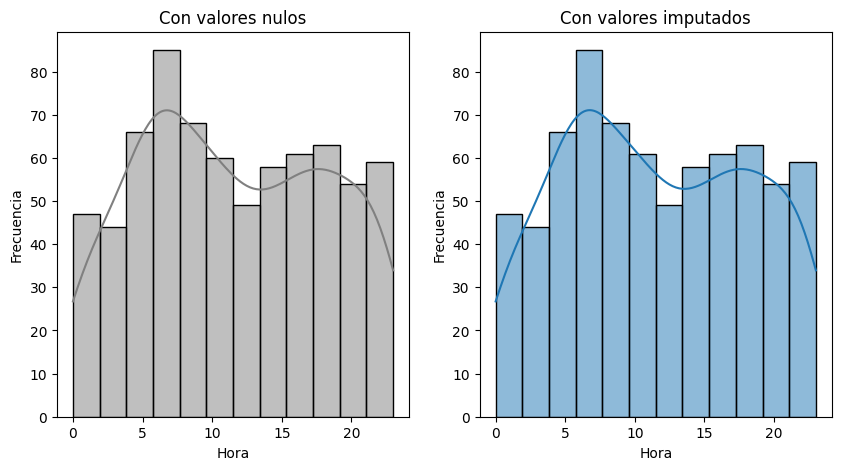

In [211]:
fig, ax= plt.subplots(1,2, figsize=(10,5))

sns.histplot(data=df,x=df['hora'].dt.hour, bins=12,kde=True,ax=ax[0],color='gray')
ax[0].set_title('Con valores nulos')
ax[0].set_xlabel('Hora')
ax[0].set_ylabel('Frecuencia')

sns.histplot(data=df_hora_media,x=df_hora_media['hora'].dt.hour, bins=12,kde=True,ax=ax[1])
ax[1].set_title('Con valores imputados')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Frecuencia')
plt.show()


Es importante observar como además de al imputar los valores faltantes la distribución de los datos *hora* no cambia, se puede reconocer un patrón donde se aprecia en que horarios hay mayor cantidad de siniestros.

<Axes: xlabel='hora', ylabel='Count'>

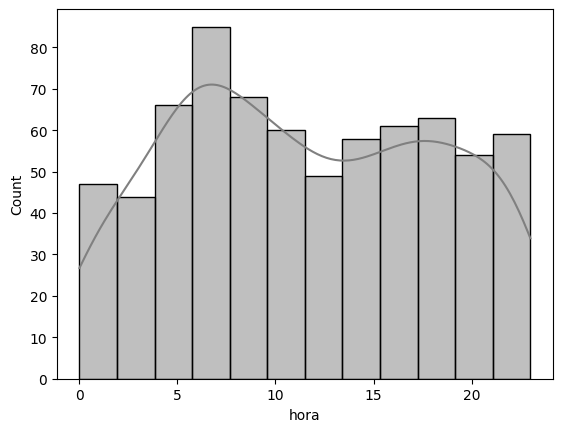

In [212]:
sns.histplot(data=df,x=df['hora'].dt.hour, bins=12,kde=True,color='gray')

### INSIGHT
La mayoría de los accidentes se dan en la franja horaria comprendidad aproximadamente entre las 5:00 y las 12:00 horas. Sin embargo hay otra franja horaria que no hay que descartar que es entre las 15:00 y las 20:00 horas.

In [213]:
#Modifico el dataframe df con los valores imputados
df = df_hora_media.copy()

### Victima

In [214]:
proporcion_nulos=df['victima'].isnull().sum()*100/len(df['victima'])
print('Proporción de nulos en la columna victima:',round(proporcion_nulos,2),'%')

Proporción de nulos en la columna victima: 1.12 %


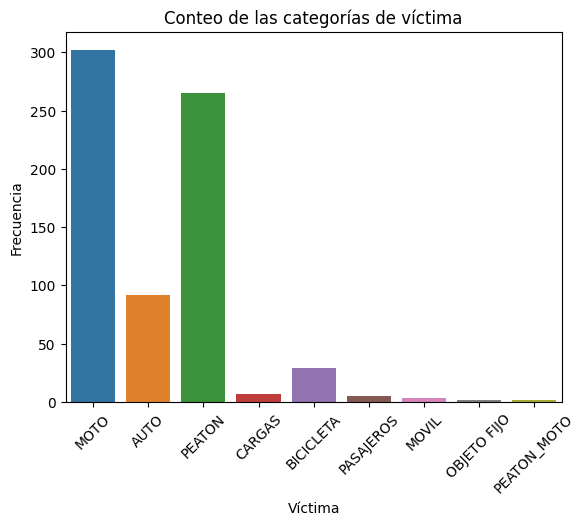

In [215]:
ax=sns.countplot(data=df,x=df['victima'], hue=df['victima'],legend=False)
plt.xticks(fontsize=10, rotation=45);
ax.set_title('Conteo de las categorías de víctima')
ax.set_xlabel('Víctima')
ax.set_ylabel('Frecuencia');

In [216]:
conteo_victimas=df['victima'].value_counts()

In [217]:
print('Conteo de las categorías de víctima:')
for victima in conteo_victimas.index:
    print(victima,':',round(conteo_victimas[victima]*100/conteo_victimas.sum(),2),'%')

Conteo de las categorías de víctima:
MOTO : 42.72 %
PEATON : 37.48 %
AUTO : 13.01 %
BICICLETA : 4.1 %
CARGAS : 0.99 %
PASAJEROS : 0.71 %
MOVIL : 0.42 %
OBJETO FIJO : 0.28 %
PEATON_MOTO : 0.28 %


Al ver los datos nulos estos representan un poco más deñ 1% de los mismos y es una de las categorías con mayor importancia con respecto al objetivo del análisis. Por lo que se decide eliminar las filas que no contengan los datos de las víctimas. Ya que al imputar cualquier valor no tendría ningun sentido debido a la gran diferencia entre las categorias dominantes (*MOTO* y *PEATON*) y el resto.

In [218]:
df.dropna(subset=['victima'],inplace=True)

Además vamos a verificar el valor *PEATON_MOTO* de la categoría víctima que solo tiene 2 registros.

In [219]:
df[df['victima']=='PEATON_MOTO']

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,longitud,latitud,involucrados,victima,acusado,rol,sexo,edad
600,2020-0063,2,2020-12-05,1900-01-01 07:10:00,NUEVA YORK Y ALTA GRACIA,CALLE,11,-58.527838,-34.61047,PEATON_MOTO-MOTO,PEATON_MOTO,MOTO,PEATON,MASCULINO,38.0
601,2020-0063,2,2020-12-05,1900-01-01 07:10:00,NUEVA YORK Y ALTA GRACIA,CALLE,11,-58.527838,-34.61047,PEATON_MOTO-MOTO,PEATON_MOTO,MOTO,PASAJERO_ACOMPAÑANTE,MASCULINO,21.0


Suponemos que estos registros tienen un error a la hora de ingresar datos y ese valor seria el de la categoría *acusados*.

In [220]:
df.loc[df['victima'] == 'PEATON_MOTO', ['involucrados', 'victima']] = ['MOTO-MOTO', 'MOTO']

### INSIGHT
Se observa como la gran cantidad de víctimas son personas que utilizan motos y peatones, estas dos categorías suman poco mas del 77% de las víctimas, por lo que son 2 categorías de suma importancia.

### Acusado

In [221]:
df.isnull().sum()

id_hecho            0
cant_victimas       0
fecha               0
hora                0
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
longitud           11
latitud            11
involucrados        0
victima             0
acusado            17
rol                 3
sexo                3
edad               48
dtype: int64

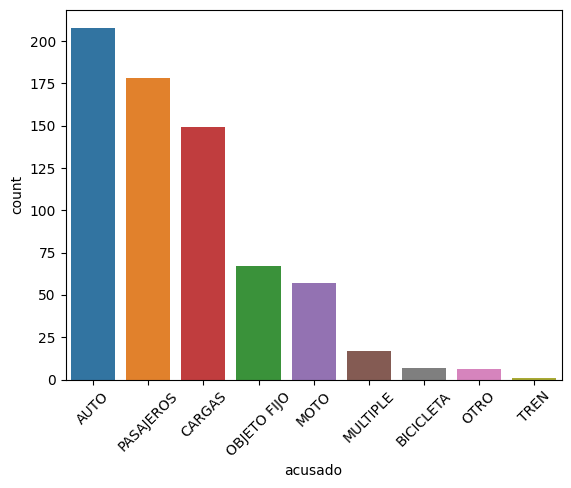

In [222]:
order = df['acusado'].value_counts().index
sns.countplot(data=df,x=df['acusado'], hue=df['acusado'],legend=False, order=order)
plt.xticks(fontsize=10, rotation=45);

A la hora de imputar valores faltantes en la categoría *acusado* buscaremos un patrón que nos permite ver que imputar en base a otra variable.

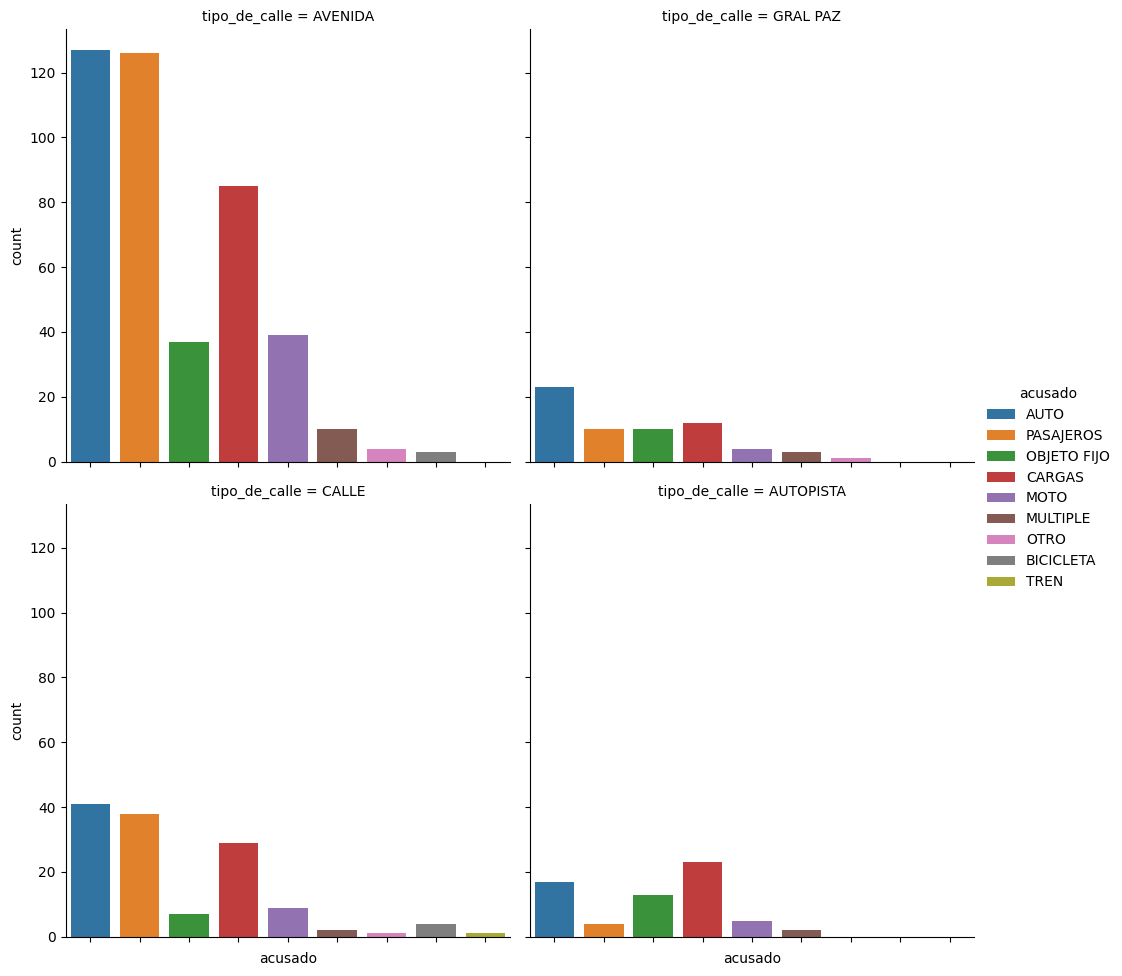

In [223]:
g=sns.catplot(data=df,x='acusado',hue='acusado',kind='count',col='tipo_de_calle',col_wrap=2)

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45)

Al explorar la cantidad de victimas por tipo de calle, no encontramos un patron definido pues generalmente la mayoria de los acusados en 3 de los 4 tipos de calle es la categoría *auto*.

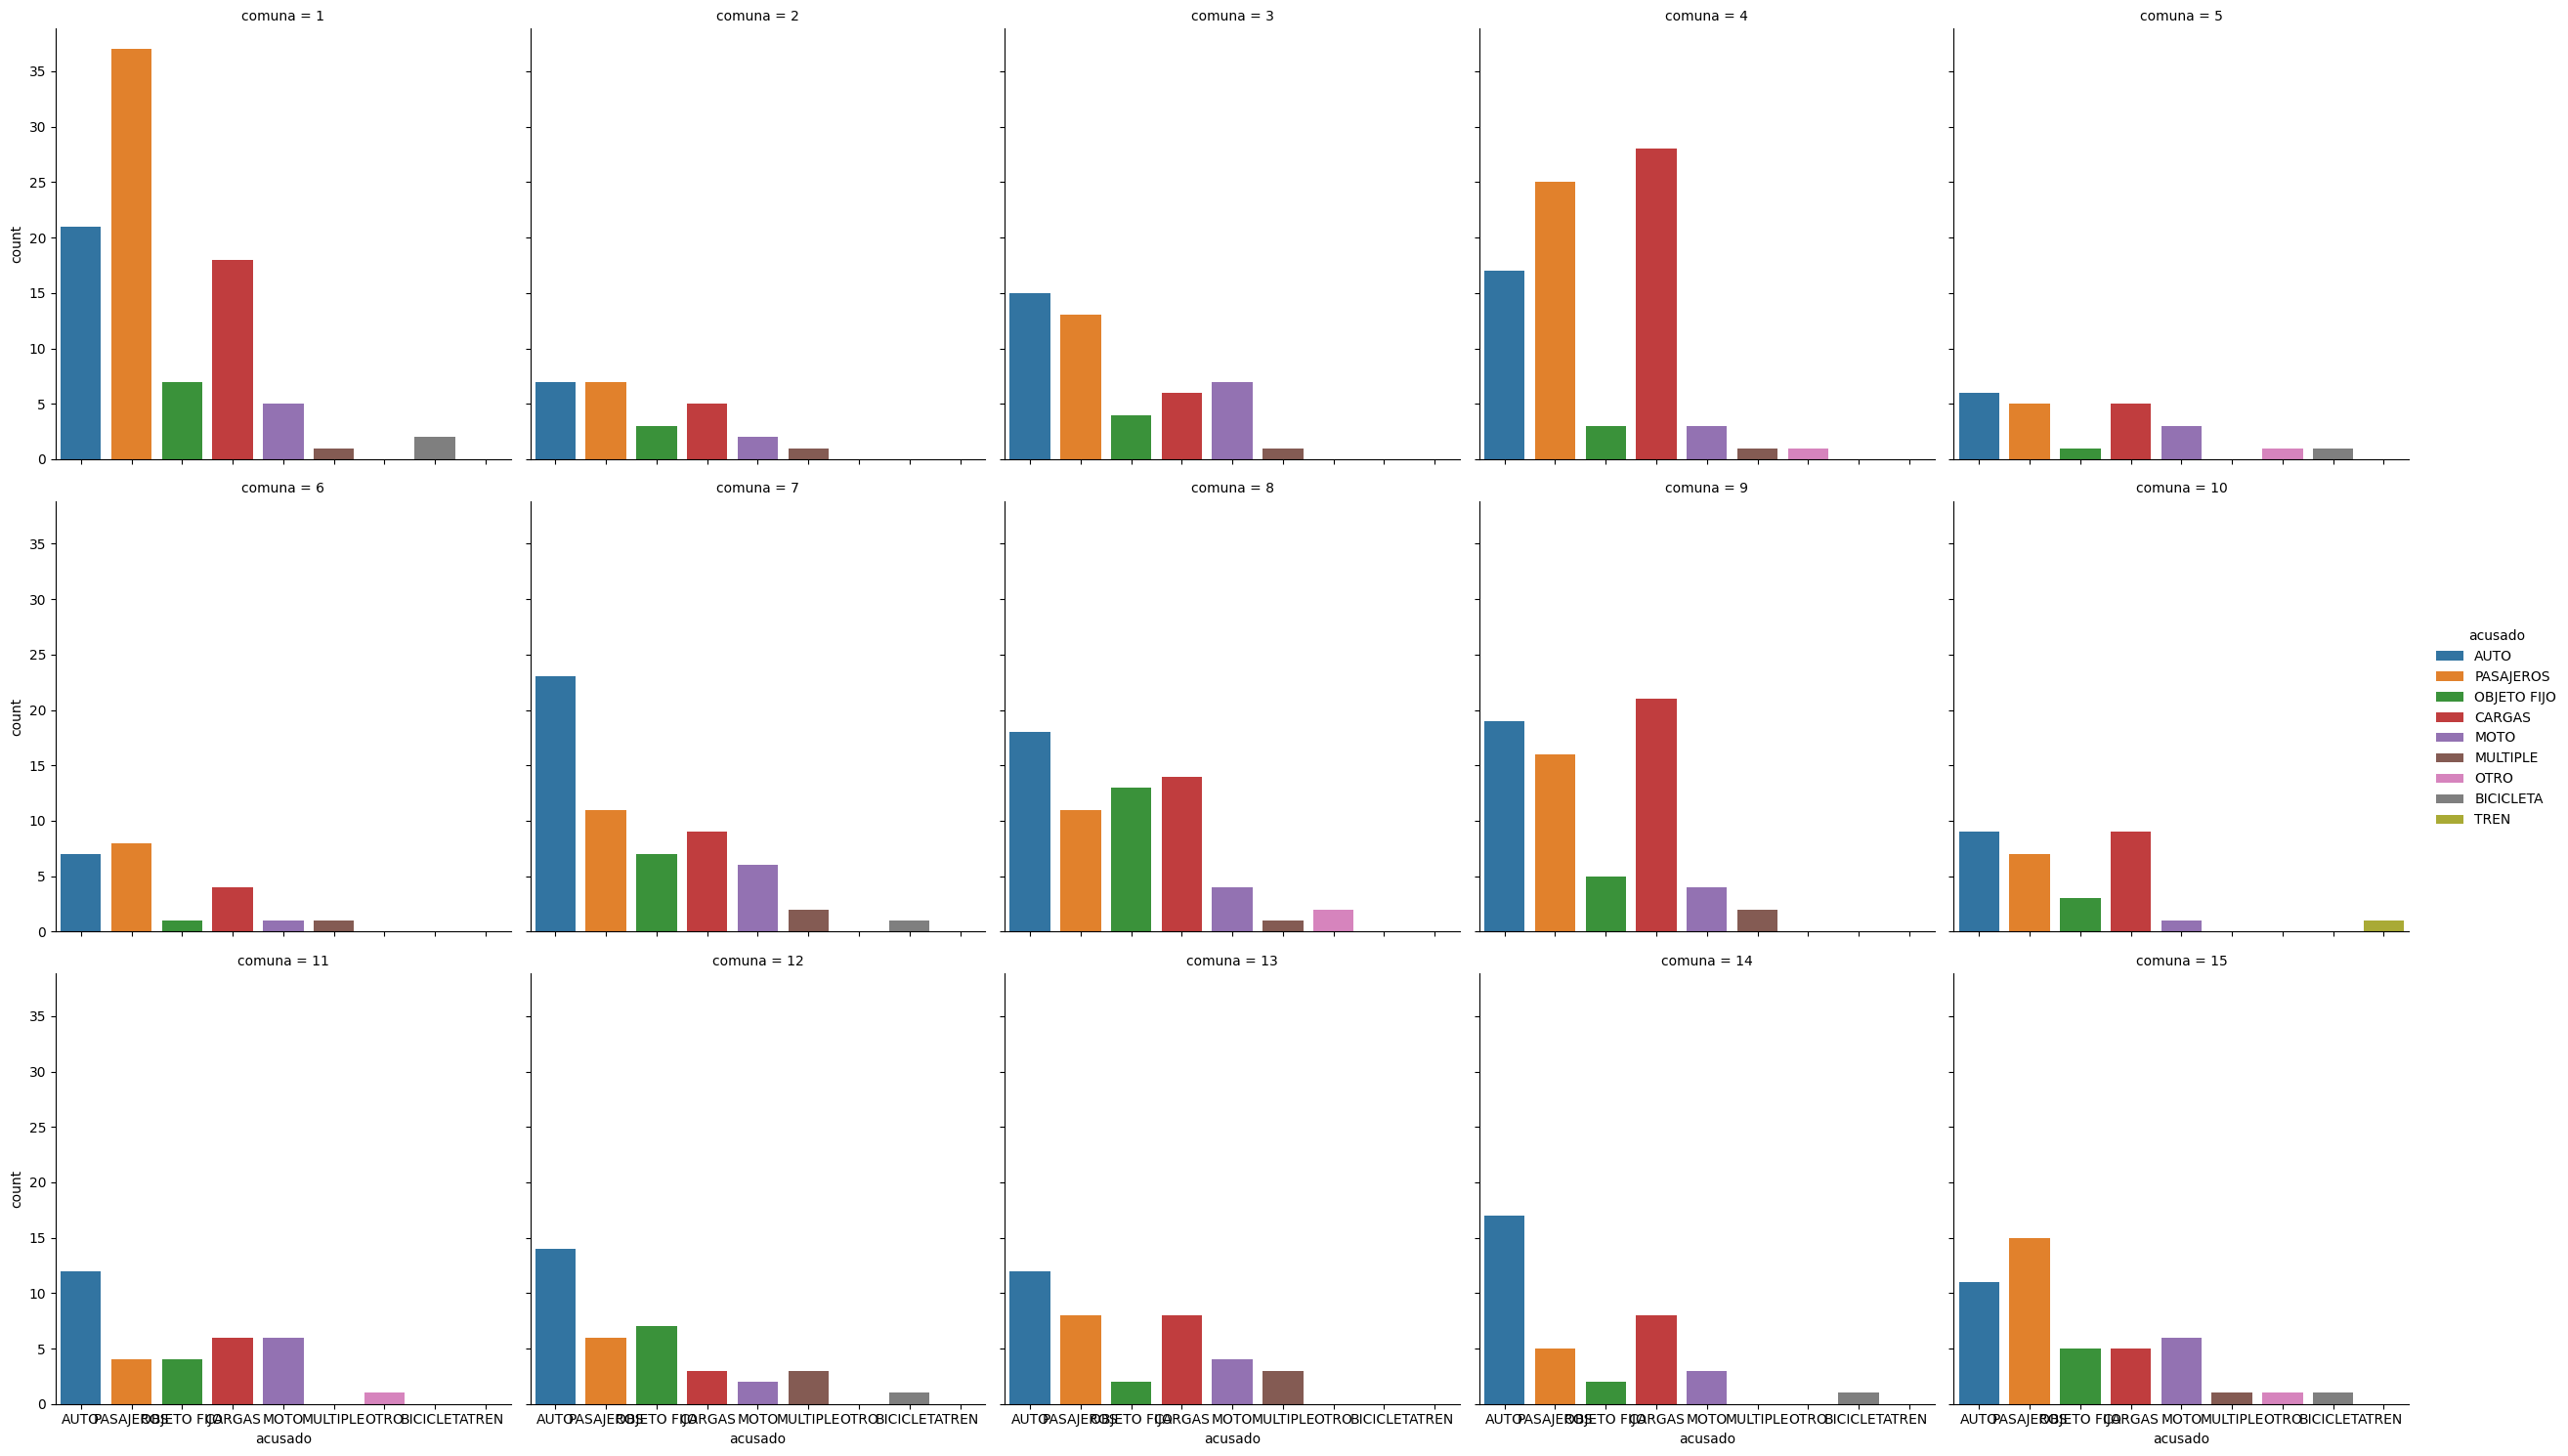

In [224]:
sns.catplot(data=df,x='acusado',hue='acusado',kind='count',col='comuna',col_wrap=5)

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45)

Aqui si se puede ver una mayor diferencia entre las comunas donde si bien la mayoria el principal acusado es *AUTO* tambien hay comunas donde categorías como *PASAJEROS* o *CARGAS* tienen mayor cantidad en los conteos.

In [225]:
maximos=df.groupby('comuna')['acusado'].value_counts()


In [226]:
data=dict()
for i in range(1,16):
    data[i]=maximos[i].idxmax()
data=pd.Series(data)

In [227]:
ids=df[df['acusado'].isnull()]['id_hecho']

In [228]:
df[df['acusado'].isnull()]

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,longitud,latitud,involucrados,victima,acusado,rol,sexo,edad
3,2016-0004,1,2016-01-10,1900-01-01 00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,8,-58.465039,-34.680930,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,18.0
33,2016-0045,1,2016-04-11,1900-01-01 10:25:00,AV GRAL PAZ Y AV DEL LIBERTADOR,GRAL PAZ,13,-58.467435,-34.534769,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,NaN
39,2016-0052,1,2016-04-20,1900-01-01 20:00:00,AUTOPISTA LUGONES PK 10000,AUTOPISTA,13,NaN,NaN,MOTO-SD,MOTO,NaN,NaN,NaN,NaN
58,2016-0080,1,2016-06-18,1900-01-01 06:42:00,AV GRAL PAZ Y AV RIVADAVIA,GRAL PAZ,9,-58.529280,-34.639318,AUTO-SD,AUTO,NaN,CONDUCTOR,MASCULINO,60.0
84,2016-0110,1,2016-08-24,1900-01-01 20:21:00,AV ALBERDI Y CARHUE,AVENIDA,9,-58.512322,-34.659035,PEATON-SD,PEATON,NaN,PEATON,MASCULINO,57.0
107,2016-0135,1,2016-10-24,1900-01-01 05:00:00,AV FIGUEROA ALCORTA Y PINEDO,AVENIDA,14,-58.422602,-34.564037,PEATON-SD,PEATON,NaN,PEATON,MASCULINO,29.0
114,2016-0143,1,2016-11-06,1900-01-01 04:41:00,AV 27 DE FEBRERO Y AV ESCALADA,AVENIDA,8,-58.444513,-34.684759,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,35.0
127,2016-0159,1,2016-12-04,1900-01-01 07:21:00,AV 27 DE FEBRERO Y AV ESCALADA,AVENIDA,8,-58.444513,-34.684759,AUTO-SD,AUTO,NaN,CONDUCTOR,MASCULINO,23.0
160,2017-0025,1,2017-02-24,1900-01-01 17:05:00,AV. FERNANDEZ DE LA CRUZ Y RIVERA INDARTE,AVENIDA,7,-58.436144,-34.654246,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,23.0
202,2017-0069,1,2017-05-24,1900-01-01 14:15:00,AV. GRAL. PAZ Y ULRICO SCHMIDL,GRAL PAZ,9,-58.521731,-34.659975,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,39.0


In [229]:
df['acusado']=df['acusado'].fillna(df['comuna'].map(data))

Se han imputado valores faltantes a la variable *acusado* basandonos en el máximo de cada comuna para no alterar lo mínimo posible la distribución tanto de la categoría *acusado* como la cantidad de victimas por comuna.

### Rol

In [230]:
df['rol'].value_counts(normalize=True)

rol
CONDUCTOR               0.468750
PEATON                  0.377841
PASAJERO_ACOMPAÑANTE    0.112216
CICLISTA                0.041193
Name: proportion, dtype: float64

In [231]:
df['rol'].isnull().sum()*100/df['rol'].count()

0.42613636363636365

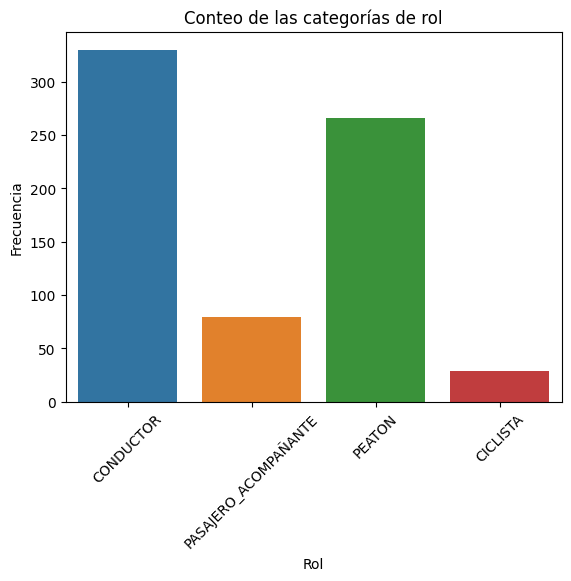

In [232]:
ax=sns.countplot(data=df,x=df['rol'], hue=df['rol'],legend=False)
ax.set_title('Conteo de las categorías de rol')
ax.set_xlabel('Rol')
ax.set_ylabel('Frecuencia')
plt.xticks(fontsize=10, rotation=45);

Se aprecia que en la variable *rol* tanto *CONDUCTOR* como *PEATON* representaN alrededor el 47% y el 38% respectivamente es decir que ambas categorias representan el 85% aproximadamente del total. Por lo que la imputacion de valores faltantes sera mendiante la moda que en este caso es *CONDUCTOR*.

In [233]:
df['rol'].fillna(df['rol'].mode()[0],inplace=True)

In [234]:
df.isnull().sum()

id_hecho            0
cant_victimas       0
fecha               0
hora                0
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
longitud           11
latitud            11
involucrados        0
victima             0
acusado             0
rol                 0
sexo                3
edad               48
dtype: int64

### Edad

In [235]:
df['edad'].isnull().sum()*100/df['edad'].count()

7.283763277693475

In [236]:
df['edad'].describe()

count    659.000000
mean      42.075873
std       19.746271
min        1.000000
25%       27.000000
50%       37.000000
75%       56.000000
max       95.000000
Name: edad, dtype: float64

In [237]:
df['edad'].mode()

0    30.0
Name: edad, dtype: float64

In [238]:
media=df['edad'].mean()
mediana=df['edad'].median()
moda=df['edad'].mode()[0]

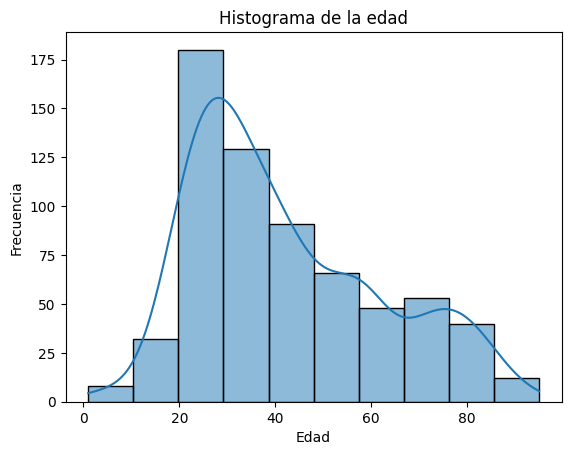

In [239]:
ax=sns.histplot(data=df,x='edad',bins=10,kde=True)
ax.set_title('Histograma de la edad')
ax.set_xlabel('Edad')
ax.set_ylabel('Frecuencia');

In [240]:
poblacion_activa=df[(df['edad']>=15) & (df['edad']<=64)]['edad'].count()*100/df['edad'].count()

In [241]:
print("Porcentaje de poblacion activa:",round(poblacion_activa,2),"%")

Porcentaje de poblacion activa: 81.79 %


Lo primero que se puede decir del histograma es que la media es mayor que la mediana por lo que estamos ante la presencia de un histograma sesgado a la derecha.

### INSIGHT
En segundo lugar 81.79% de las victimas se encuentra en lo que se conoce como población potencialmente activa que esta en el rango etario de 15 a 64 años segun [información oficial](https://www.argentina.gob.ar/pais/poblacion/proyecciones).

In [242]:
df_edad_media=df.copy()
df_edad_mediana=df.copy()
df_edad_moda=df.copy()
df_edad_muestreo=df.copy()

In [243]:
df_edad_media['edad']=df_edad_media['edad'].fillna(media)
df_edad_mediana['edad']=df_edad_mediana['edad'].fillna(mediana)
df_edad_moda['edad']=df_edad_moda['edad'].fillna(moda)


In [244]:
# Crear una copia de la columna 'edad' sin los valores nulos
edad_sin_nan = df_edad_muestreo['edad'].dropna()

# Crear una máscara booleana para los valores nulos en la columna 'edad'
mask = df_edad_muestreo['edad'].isnull()

# Imputar los valores nulos en 'edad' con valores muestreados aleatoriamente de 'edad_sin_nan'
df_edad_muestreo.loc[mask, 'edad'] = np.random.choice(edad_sin_nan, size=mask.sum())

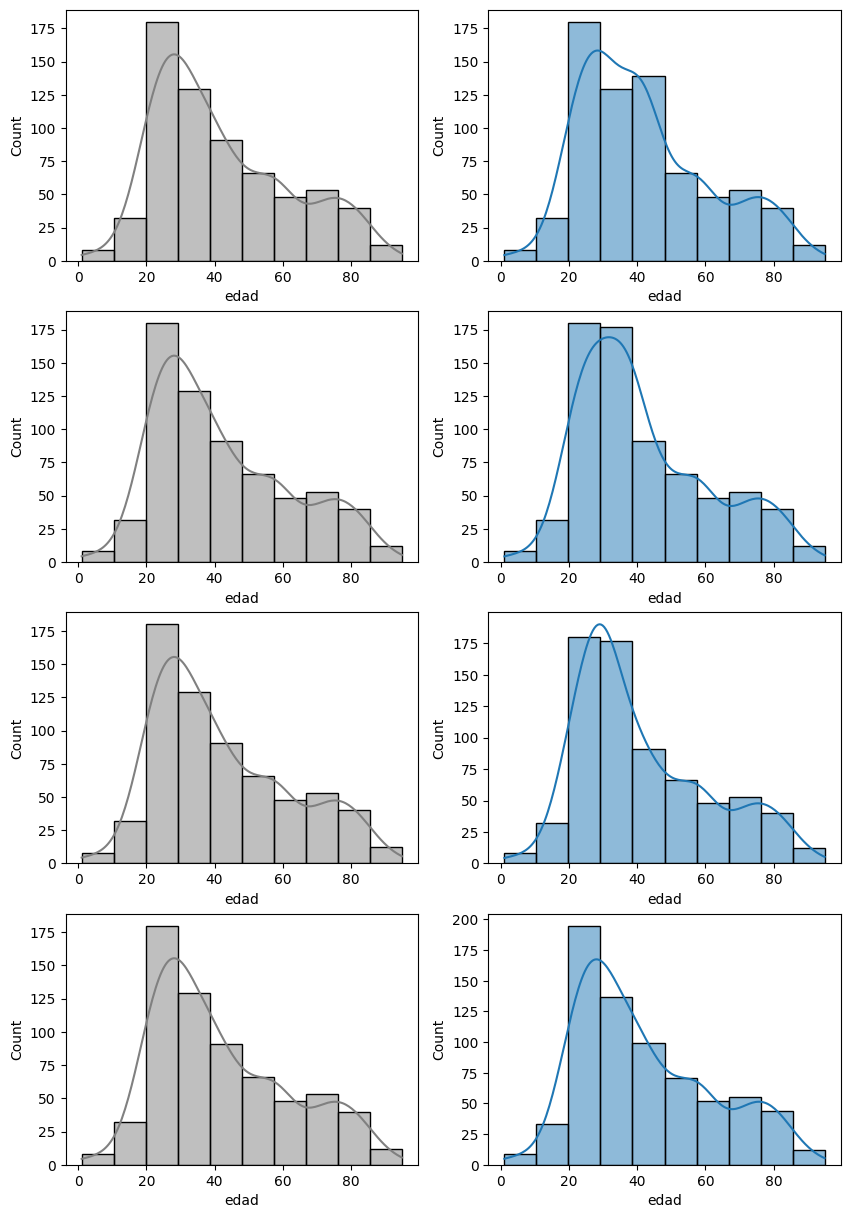

In [245]:
fig, ax= plt.subplots(4,2, figsize=(10,15))

sns.histplot(data=df,x='edad',bins=10,kde=True,ax=ax[0][0],color='gray')

sns.histplot(data=df_edad_media,x='edad',bins=10,kde=True,ax=ax[0][1])

sns.histplot(data=df,x='edad',bins=10,kde=True,ax=ax[1][0],color='gray')

sns.histplot(data=df_edad_mediana,x='edad',bins=10,kde=True,ax=ax[1][1])

sns.histplot(data=df,x='edad',bins=10,kde=True,ax=ax[2][0],color='gray')

sns.histplot(data=df_edad_moda,x='edad',bins=10,kde=True,ax=ax[2][1])

sns.histplot(data=df,x='edad',bins=10,kde=True,ax=ax[3][0],color='gray')

sns.histplot(data=df_edad_muestreo,x='edad',bins=10,kde=True,ax=ax[3][1]);


A la hora de imputar valores faltantes lo haremos mediante el método de muestro realizado con pandas ya que es el unico que mantien la distribución de datos.

In [246]:
df=df_edad_muestreo.copy()

### Sexo

In [247]:
df['sexo'].isnull().sum()*100/df['sexo'].count()

0.42613636363636365

In [248]:
df['sexo'].value_counts(normalize=True)

sexo
MASCULINO    0.765625
FEMENINO     0.234375
Name: proportion, dtype: float64

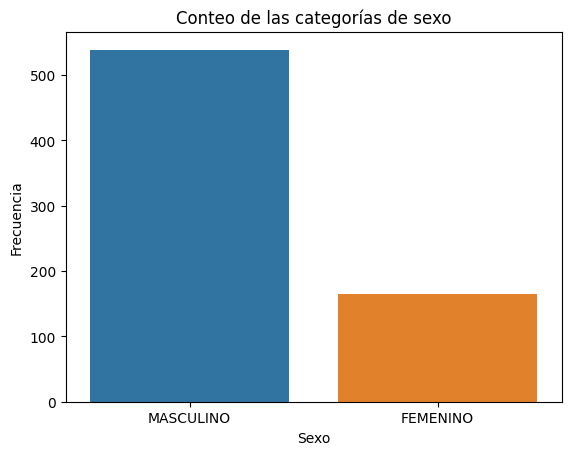

In [249]:
ax=sns.countplot(data=df,x='sexo',hue='sexo',legend=False)
ax.set_title('Conteo de las categorías de sexo')
ax.set_xlabel('Sexo')
ax.set_ylabel('Frecuencia');

La mayoria de las víctimas son del sexo *masculino* por lo que a los valores faltantes se le imputaran los de la mayoría debido a que solo falta el 0.42% de los datos.

In [250]:
df['sexo'].fillna(df['sexo'].mode()[0],inplace=True)

In [251]:
df.isnull().sum()

id_hecho            0
cant_victimas       0
fecha               0
hora                0
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
longitud           11
latitud            11
involucrados        0
victima             0
acusado             0
rol                 0
sexo                0
edad                0
dtype: int64

### Latitud y Longitud

In [252]:
df[df['latitud'].isnull()]

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,longitud,latitud,involucrados,victima,acusado,rol,sexo,edad
39,2016-0052,1,2016-04-20,1900-01-01 20:00:00,AUTOPISTA LUGONES PK 10000,AUTOPISTA,13,NaN,NaN,MOTO-SD,MOTO,AUTO,CONDUCTOR,MASCULINO,5.0
108,2016-0136,1,2016-10-25,1900-01-01 00:00:00,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,4,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,MASCULINO,39.0
180,2017-0042,1,2017-04-10,1900-01-01 09:00:00,AV. LEOPOLDO LUGONES PKM 6900,GRAL PAZ,14,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,MASCULINO,34.0
184,2017-0050,2,2017-04-28,1900-01-01 11:08:08,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,9,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,MASCULINO,46.0
185,2017-0050,2,2017-04-28,1900-01-01 11:08:08,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,9,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,PASAJERO_ACOMPAÑANTE,MASCULINO,16.0
186,2017-0051,1,2017-05-01,1900-01-01 03:47:47,AU DELLEPIANE 2400,AUTOPISTA,7,NaN,NaN,AUTO-AUTO,AUTO,AUTO,CONDUCTOR,MASCULINO,33.0
264,2017-0140,1,2017-11-19,1900-01-01 23:22:17,AU ARTURO FRONDIZI PKM 3100,AUTOPISTA,4,NaN,NaN,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,24.0
325,2018-0039,1,2018-04-21,1900-01-01 22:15:00,AUTOPISTA LUGONES KM 4.7,AUTOPISTA,14,NaN,NaN,PEATON-AUTO,PEATON,AUTO,PEATON,MASCULINO,37.0
562,2020-0026,1,2020-05-17,1900-01-01 06:40:00,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA,14,NaN,NaN,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO,CONDUCTOR,MASCULINO,28.0
576,2020-0039,1,2020-09-01,1900-01-01 19:17:42,MURGUIONDO 2700,CALLE,9,NaN,NaN,PEATON-CARGAS,PEATON,CARGAS,PEATON,MASCULINO,44.0


Se elimina la primera fila debido a que tiene demasiados valores nulos

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 714
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_hecho         707 non-null    object        
 1   cant_victimas    707 non-null    int64         
 2   fecha            707 non-null    datetime64[ns]
 3   hora             707 non-null    datetime64[ns]
 4   lugar_del_hecho  707 non-null    object        
 5   tipo_de_calle    707 non-null    object        
 6   comuna           707 non-null    int64         
 7   longitud         696 non-null    float64       
 8   latitud          696 non-null    float64       
 9   involucrados     707 non-null    object        
 10  victima          707 non-null    object        
 11  acusado          707 non-null    object        
 12  rol              707 non-null    object        
 13  sexo             707 non-null    object        
 14  edad             707 non-null    float64       

En el caso de los valores faltantes de las latitudes y longitudes se dejan para su posterior analisis con la herramienta gráfica.

Ya que imputamos los valores faltantes guardaermos el archivo para posterior uso de estos datos en herramientas de visualización.

In [254]:
df['involucrados']=df['victima'].str.cat(df['acusado'], sep='-')

In [255]:
df.to_excel('Datasets/data_final.xlsx',index=False)

In [290]:
df=pd.read_excel('Datasets/data_final.xlsx')

In [291]:
df

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,longitud,latitud,involucrados,victima,acusado,rol,sexo,edad
0,2016-0001,1,2016-01-01,1900-01-01 04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,19
1,2016-0002,1,2016-01-02,1900-01-01 01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,CONDUCTOR,MASCULINO,70
2,2016-0003,1,2016-01-03,1900-01-01 07:00:00,AV ENTRE RIOS 2034,AVENIDA,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,30
3,2016-0004,1,2016-01-10,1900-01-01 00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,8,-58.465039,-34.680930,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,18
4,2016-0005,1,2016-01-21,1900-01-01 05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2021-0093,1,2021-12-13,1900-01-01 17:10:00,AV. RIESTRA Y MOM,AVENIDA,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,PASAJERO_ACOMPAÑANTE,FEMENINO,18
703,2021-0094,1,2021-12-20,1900-01-01 01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,PASAJERO_ACOMPAÑANTE,FEMENINO,43
704,2021-0095,1,2021-12-30,1900-01-01 00:43:00,AV. GAONA Y TERRADA,AVENIDA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,MASCULINO,27
705,2021-0096,1,2021-12-15,1900-01-01 10:30:00,AV. EVA PERON 4071,AVENIDA,9,-58.470668,-34.650217,AUTO-CARGAS,AUTO,CARGAS,CONDUCTOR,MASCULINO,60


## Valores atípicos

<Axes: ylabel='edad'>

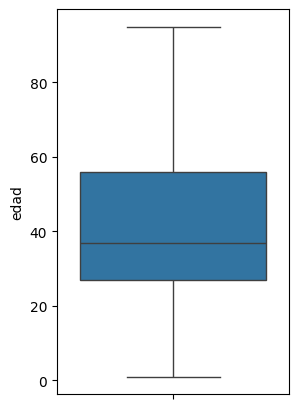

In [257]:
plt.figure(figsize=(3, 5))
sns.boxplot(data=df,y='edad')

En lo que se refiere a la edad no se observan valores atípicos.

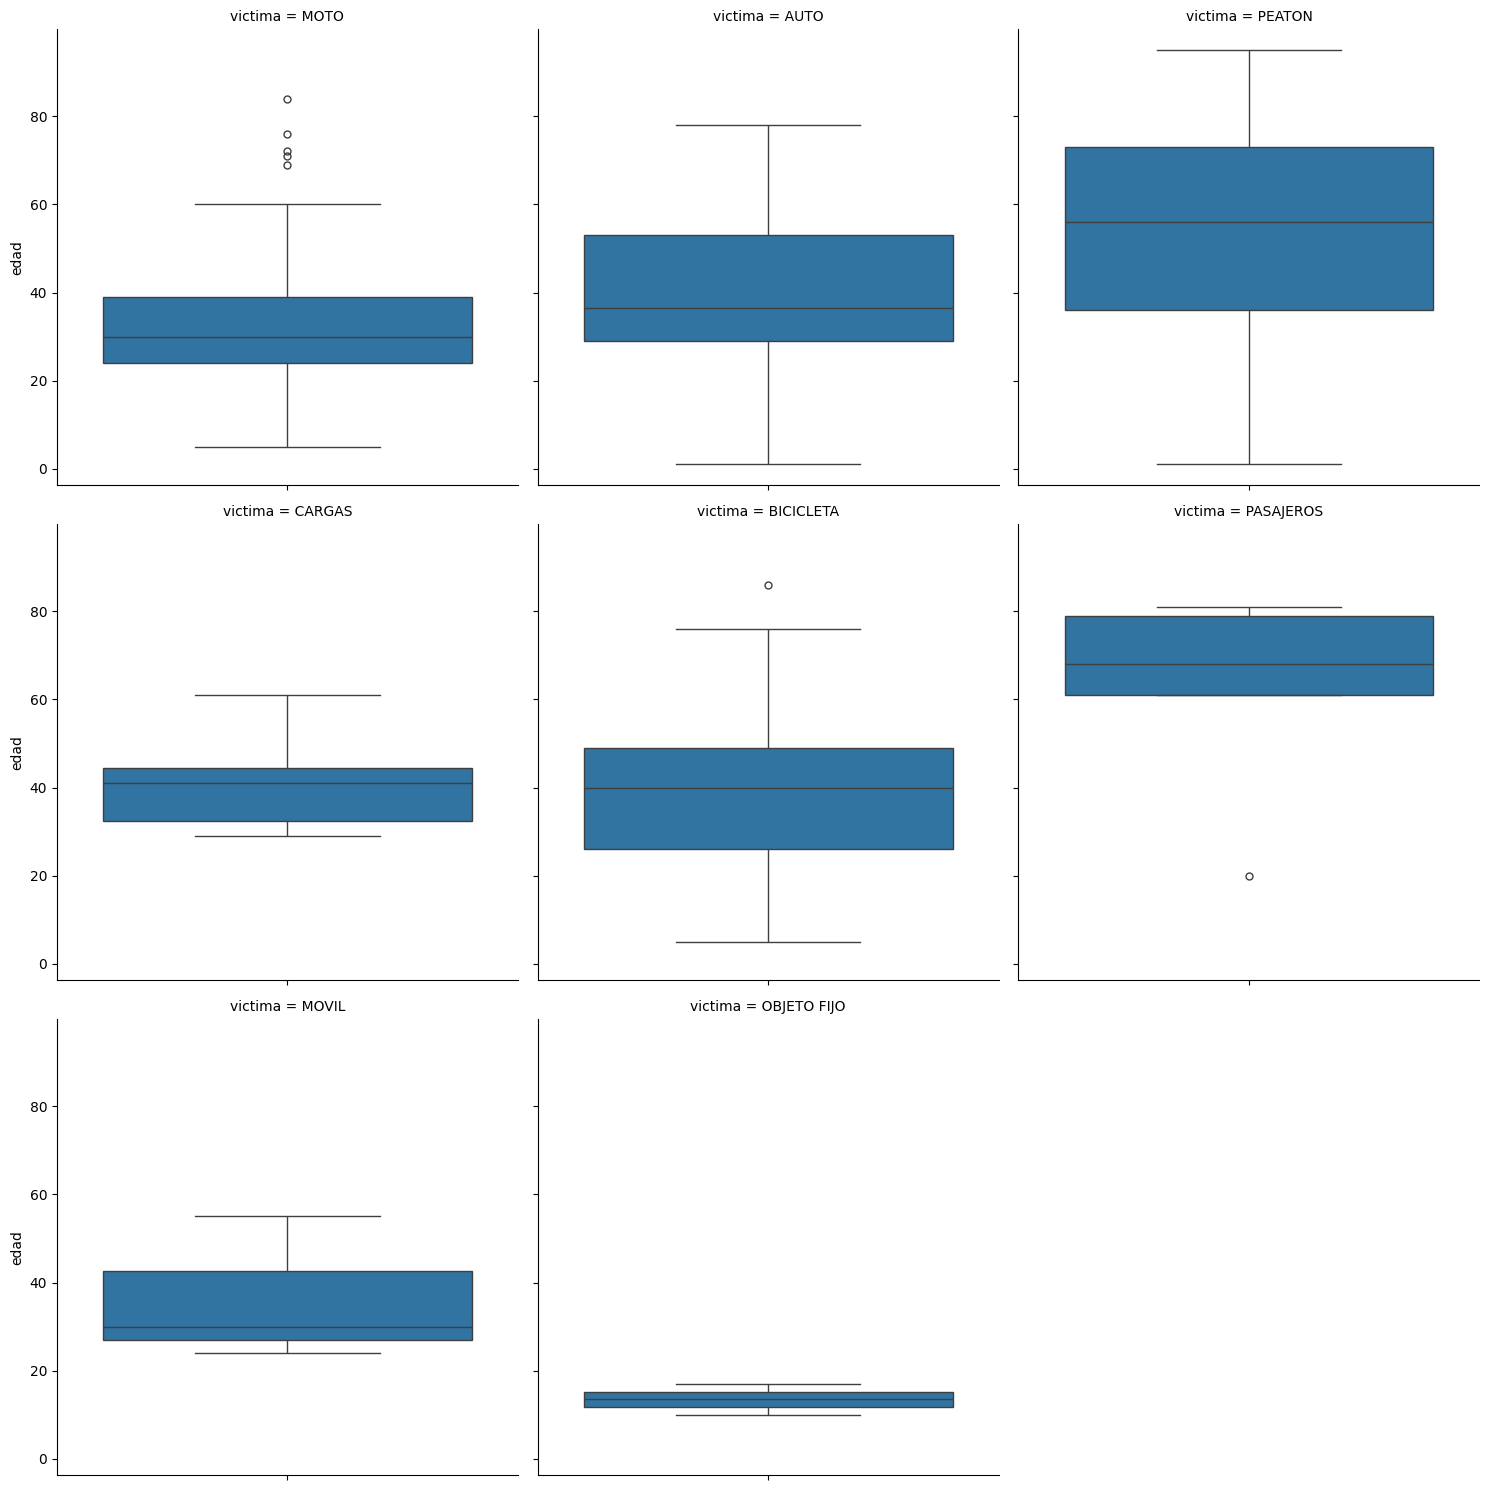

In [258]:
sns.catplot(data=df,y='edad',kind='box',col='victima',col_wrap=3);

Se observan valores atípicos dentro de la categoría *MOTO*, pero estos se van a dejar para su posterior análisis y conclusiones.

## Cantidad de víctimas

Analizaremos ahora la cantidad de victimas.


In [259]:
df['cant_victimas'].value_counts()

cant_victimas
1    666
2     38
3      3
Name: count, dtype: int64

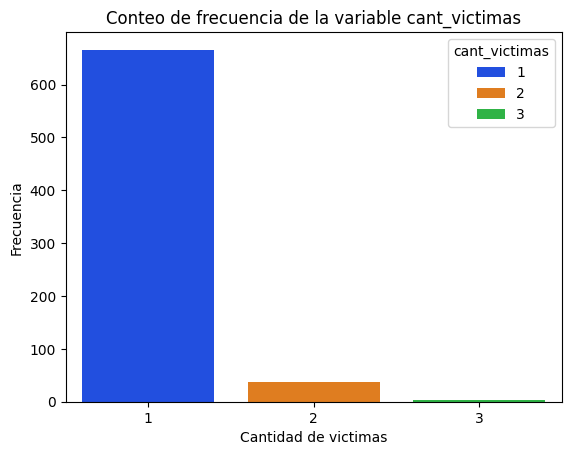

In [260]:
ax=sns.countplot(data=df, x='cant_victimas', hue='cant_victimas', palette='bright')
ax.set_title('Conteo de frecuencia de la variable cant_victimas')
ax.set_xlabel('Cantidad de victimas')
ax.set_ylabel('Frecuencia');

In [261]:
#Porcentaje de cantidad de victimas
df['cant_victimas'].value_counts()/df['cant_victimas'].count()*100

cant_victimas
1    94.200849
2     5.374823
3     0.424328
Name: count, dtype: float64

Vemos como en el 92.27% de siniestros la cantidad de víctimas es una persona

## Análisis de los siniestros en el tiempo

Con el tipo de variable *datetime* se puede analizar mas fácilmente las fechas y los periodos típicos.

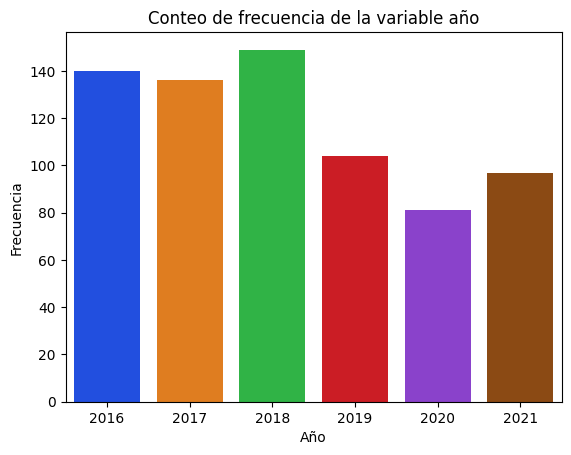

In [262]:
ax=sns.countplot(data=df, x=df['fecha'].dt.year, hue=df['fecha'].dt.year, palette='bright',legend=False)
ax.set_title('Conteo de frecuencia de la variable año')
ax.set_xlabel('Año')
ax.set_ylabel('Frecuencia');


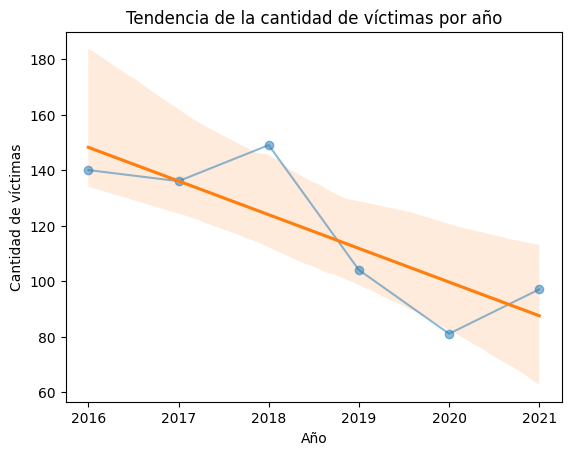

In [263]:
# Supongamos que df es tu DataFrame y 'fecha' es tu columna de fecha
df['año'] = df['fecha'].dt.year
df_yearly_count = df.groupby('año').size().reset_index(name='counts')

# Crea el gráfico de líneas
ax = df_yearly_count.plot(kind='line', x='año', y='counts', alpha=0.5, marker='o',legend=False)


# Crea el gráfico de regresión en el mismo eje
sns.regplot(data=df_yearly_count, x='año', y='counts', scatter=False, ax=ax)

ax.set_title('Tendencia de la cantidad de víctimas por año')
ax.set_xlabel('Año')
ax.set_ylabel('Cantidad de víctimas');

Si bien en el gráfico de barras se puede ver una disminución de la cantidad de siniestros en el periodo 2016 - 2021, en el gráfico que sigue podemos ver una regresión lineal con una linea de color naranja y los maximos de cada año en color celeste. 

### INSIGHT
Con este gráfico verificamos que la tendencia es hacia la baja en la cantidad de victimas por año

In [264]:
#Creo la columna semestre
df['semestre'] = (df['fecha'].dt.month - 1) // 6 + 1

#Creo la columna trimestre
df['trimestre']=df['fecha'].dt.quarter

df['bimestre'] = ((df['fecha'].dt.month - 1) // 2) + 1

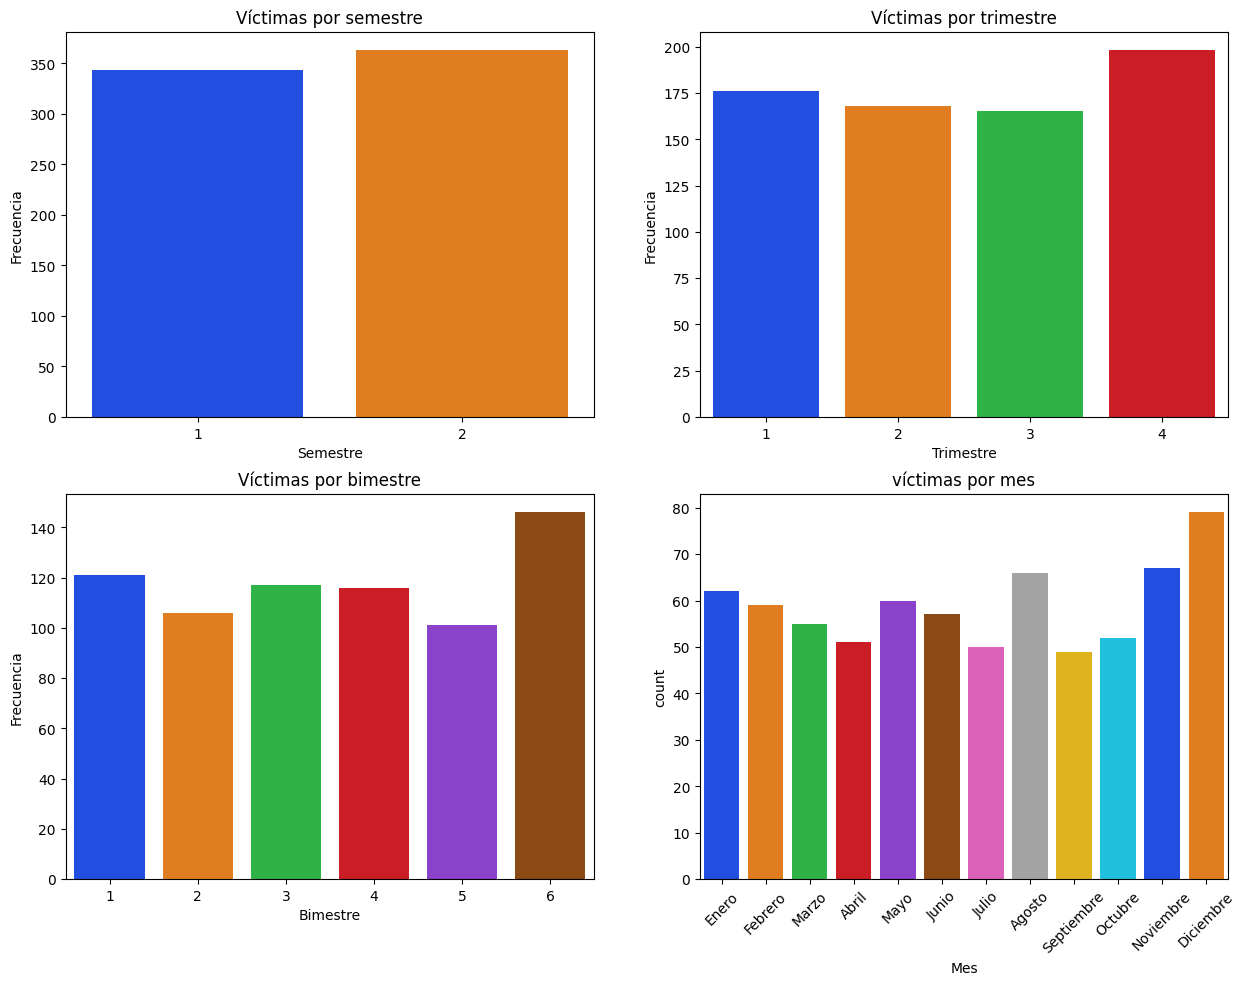

In [265]:
fig , ax = plt.subplots(2,2,figsize=(15,11))

sns.countplot(data=df, x='semestre', hue='semestre', palette='bright',legend=False,ax=ax[0][0])
ax[0][0].set_title('Víctimas por semestre')
ax[0][0].set_xlabel('Semestre')
ax[0][0].set_ylabel('Frecuencia')

sns.countplot(data=df, x='trimestre', hue='trimestre', palette='bright',legend=False,ax=ax[0][1])
ax[0][1].set_title('Víctimas por trimestre')
ax[0][1].set_xlabel('Trimestre')
ax[0][1].set_ylabel('Frecuencia')

sns.countplot(data=df, x='bimestre', hue='bimestre', palette='bright',legend=False,ax=ax[1][0])
ax[1][0].set_title('Víctimas por bimestre')
ax[1][0].set_xlabel('Bimestre')
ax[1][0].set_ylabel('Frecuencia')

sns.countplot(data=df,x=df['fecha'].dt.month_name(locale='es'),hue=df['fecha'].dt.month_name('es'),palette='bright',legend=False,ax=ax[1][1])
plt.xticks(fontsize=10, rotation=45)
ax[1][1].set_title('víctimas por mes')
ax[1][1].set_xlabel('Mes');


### INSIGHT
En el gráfico anterior se ven los periodos típicos de análisis, donde a medida que la ventana temporal se hace más pequeña la mayor cantidad de víctimas se da al final del año. Poríamos decir que el último bimestre del año es el de mayor cantidad de víctimas.

In [266]:
df['mes']=df['fecha'].dt.month_name(locale='es')
df['dia']=df['fecha'].dt.day_name(locale='es')

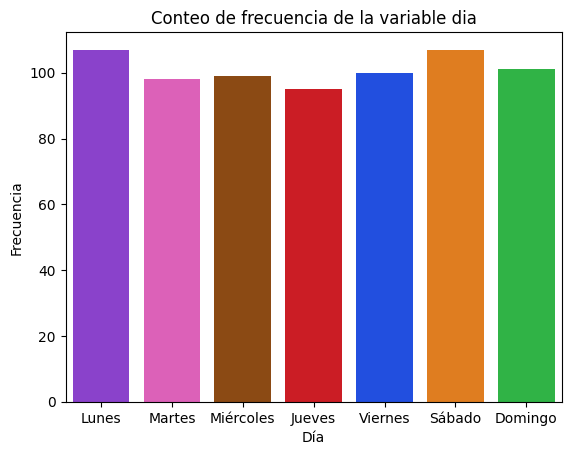

In [267]:
ax=sns.countplot(data=df,x='dia',hue='dia',palette='bright',order=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'])
ax.set_title('Conteo de frecuencia de la variable dia')
ax.set_xlabel('Día')
ax.set_ylabel('Frecuencia');

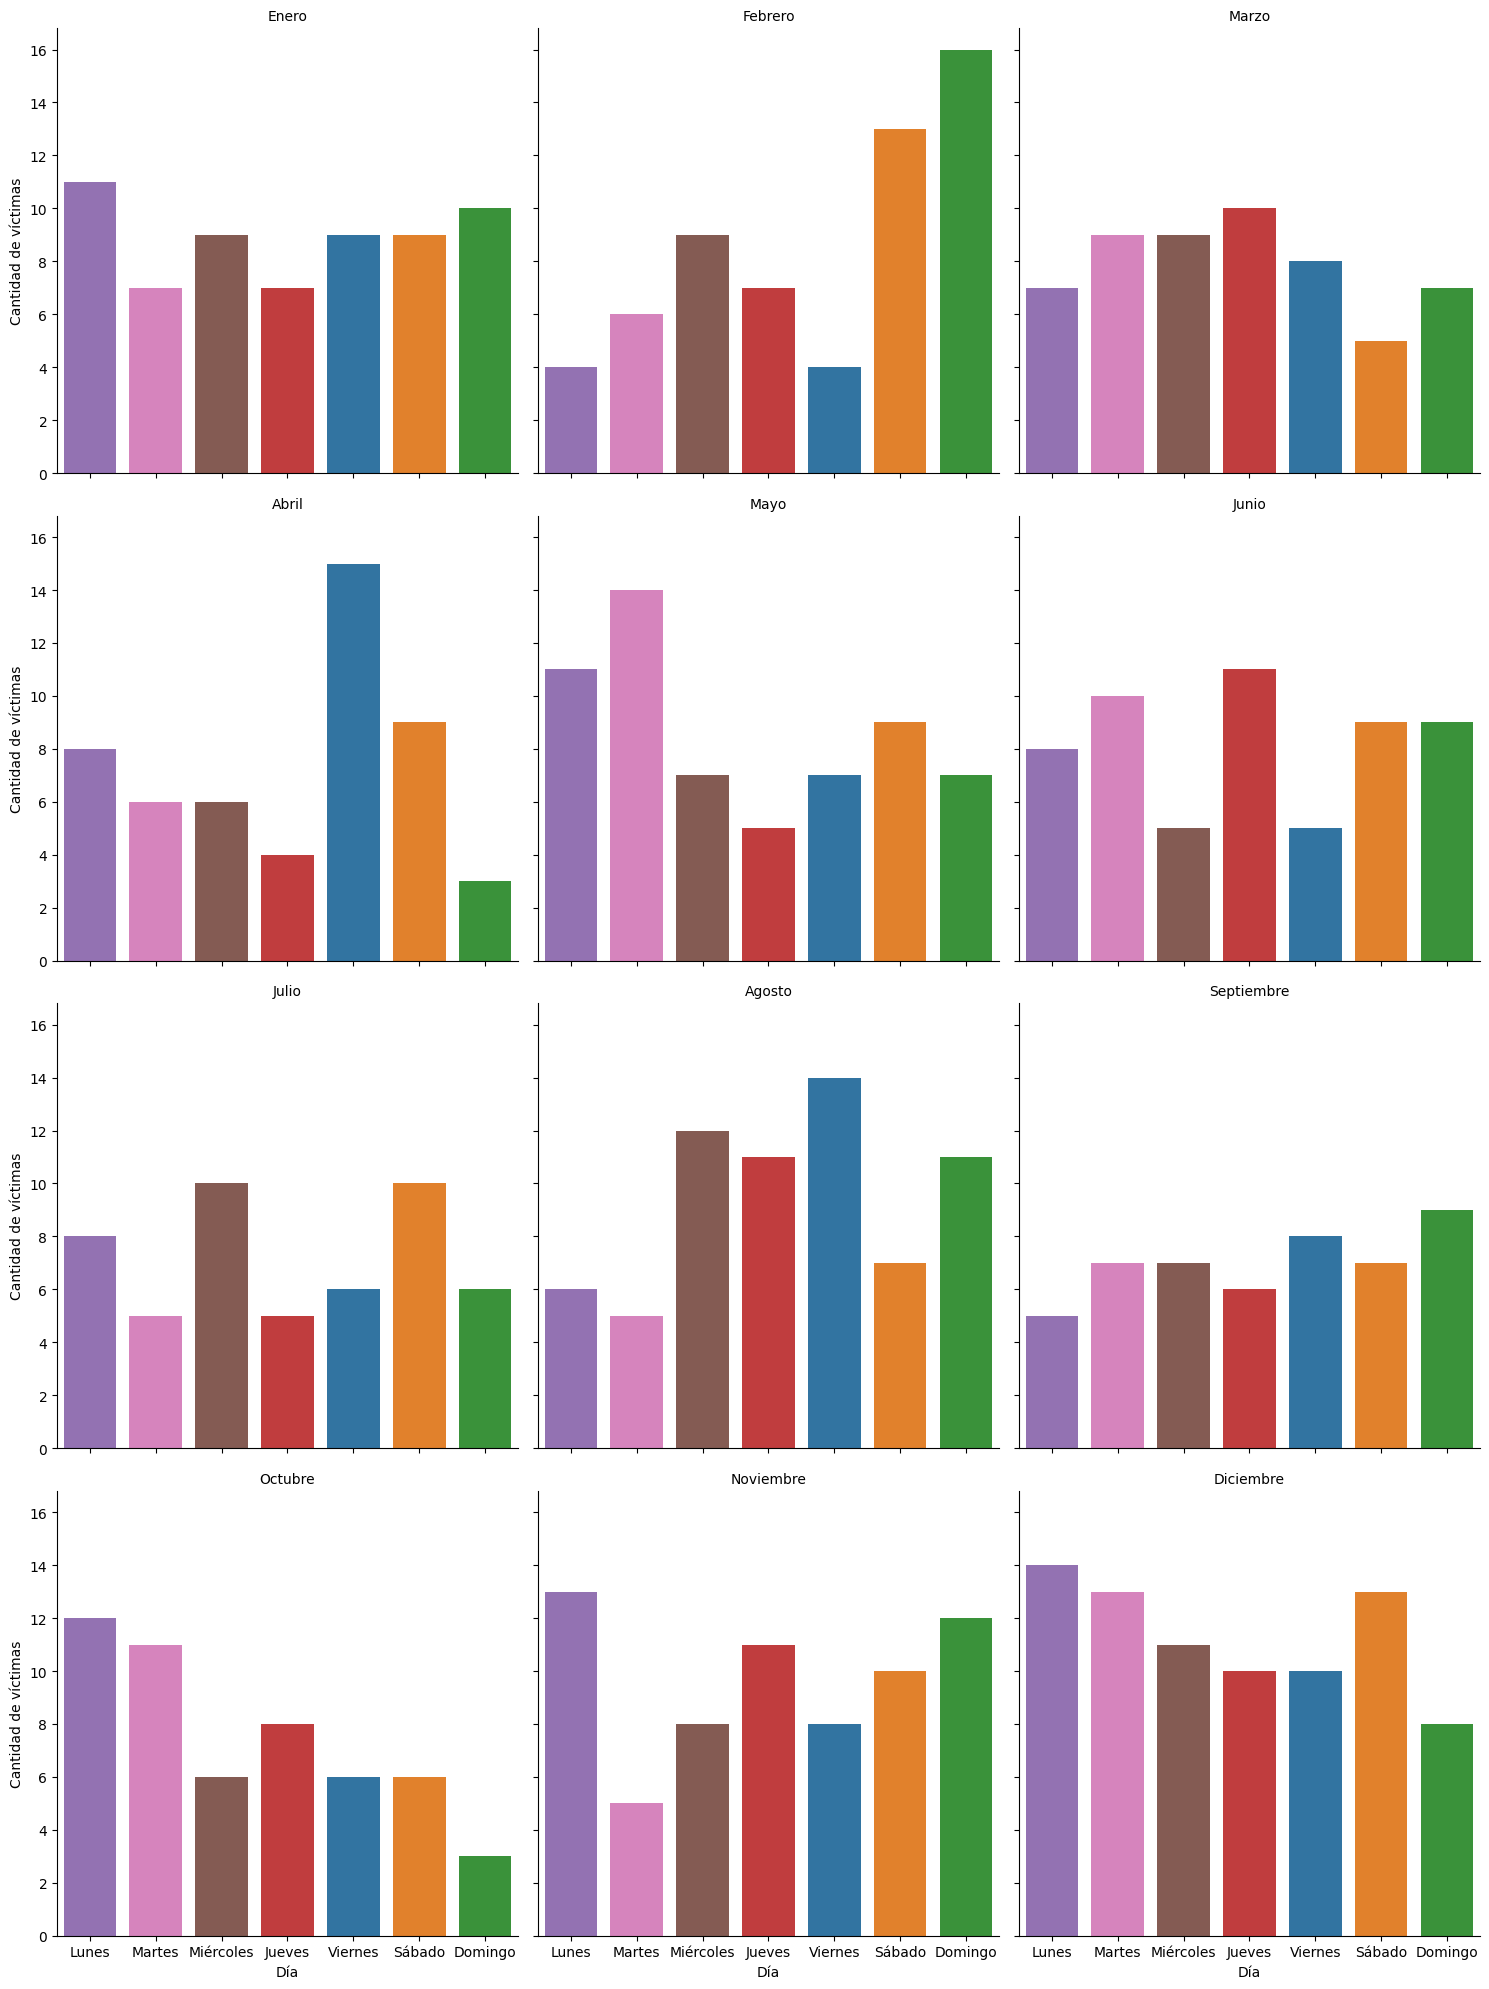

In [268]:
g=sns.catplot(data=df,x='dia',hue='dia',kind='count',col_wrap=3,col='mes',order=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'])
g.set_axis_labels('Día', 'Cantidad de víctimas')
g.set_titles("{col_name}");

### INSIGHT
Si bien al examinar los días en si mismos no parecen brindar información importante, al ver la cantidad de víctimas por día por cada mes se ve como en el último trimestre los días *lunes* son los que mayor cantidad de víctimas.

## Análisis por horas

Ahora seguiremos con el análisis de la cantidad de víctimas en base a las horas.

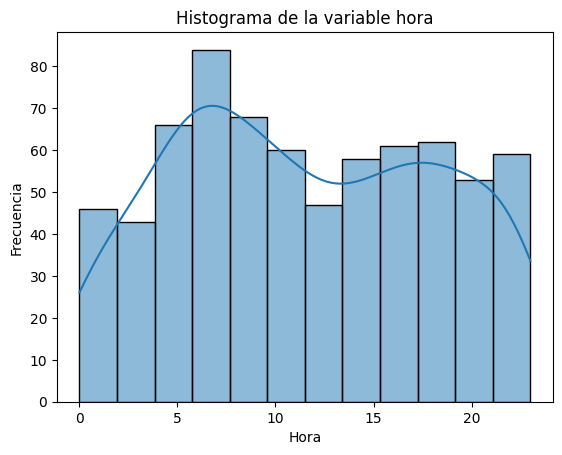

In [269]:
ax=sns.histplot(data=df,x=df['hora'].dt.hour, bins=12,kde=True)
ax.set_title('Histograma de la variable hora')
ax.set_xlabel('Hora')
ax.set_ylabel('Frecuencia');

### INSIGHT
La mayor cantidad de víctimas se dan entre las 5:00 y las 10:00 de la mañana y entre las 15:00 y las 20:00. Teniendo mayor importancia la primera franja horaria pero no podemos descartar la segunda ya que tambien aumenta el número de víctimas aunque no sea tan considerado el aumento.

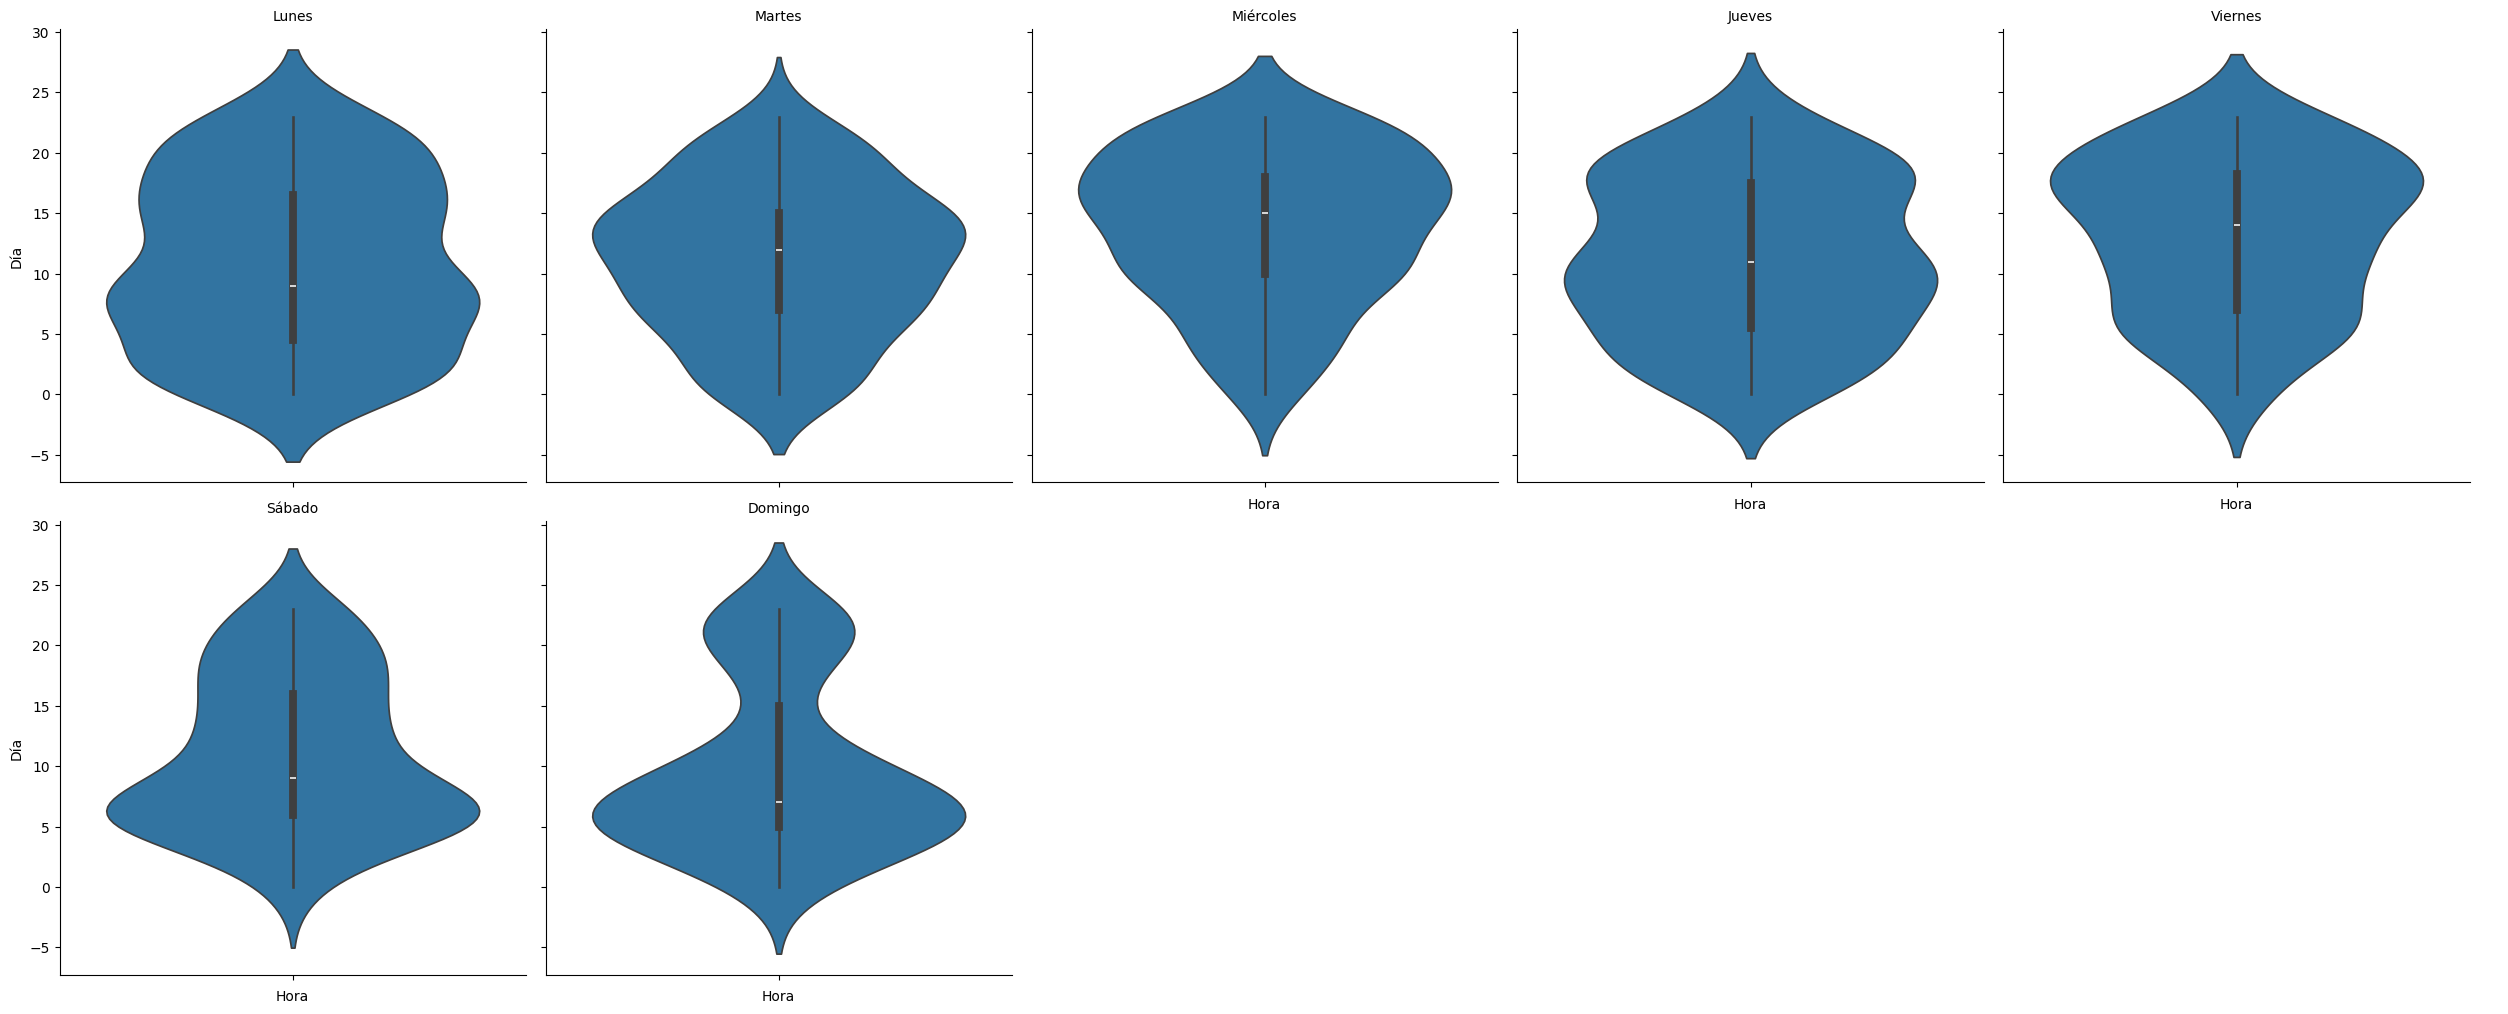

In [270]:
ax=sns.catplot(data=df, y=df['hora'].dt.hour, kind='violin', col='dia', col_wrap=5,col_order=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'])
ax.set_axis_labels('Hora', 'Día')
ax.set_titles("{col_name}");

### INSIGHT
Es importante ver la distribución de la cantidad de víctimas a lo largo de las horas en los diferentes dias de la semana.

En días laborales los la mayor cantidad de victimas se dan en horarios laborales o al regresar del trabajo, esto último se hace más evidente los viernes.

Los fines de semana la distribución cambia y es muy similar *Sabados* y *Domingos* en donde la mayor cantidad de victimas se da por la madrugada-mañana lo que sería alrededor de las 5:00 horas.

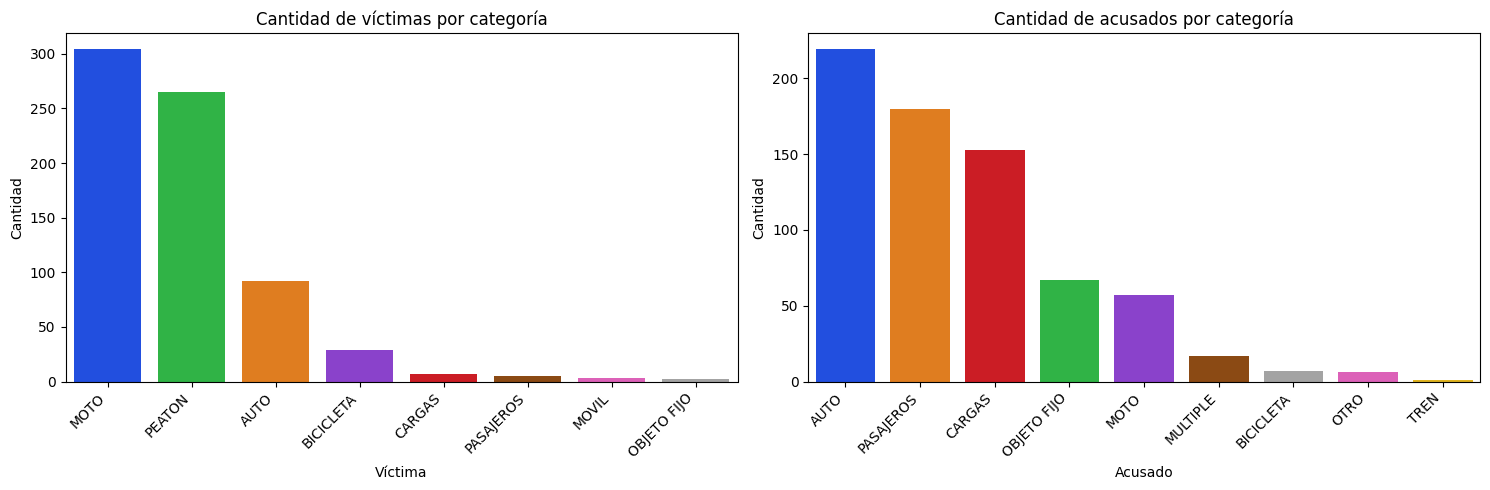

In [271]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # 1 fila, 2 columnas

# Primer gráfico
sns.countplot(data=df, x='victima', hue='victima', palette='bright', order=df['victima'].value_counts().index, ax=ax[0])
ax[0].set_title('Cantidad de víctimas por categoría')
ax[0].set_xlabel('Víctima')
ax[0].set_ylabel('Cantidad')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Segundo gráfico
# Aquí puedes poner el código para tu segundo gráfico, usando ax[1] en lugar de ax[0]
# Por ejemplo:
sns.countplot(data=df, x='acusado', hue='acusado', palette='bright', order=df['acusado'].value_counts().index, ax=ax[1])
ax[1].set_title('Cantidad de acusados por categoría')
ax[1].set_xlabel('Acusado')
ax[1].set_ylabel('Cantidad')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()  # Asegura que los gráficos no se superpongan


In [272]:
df['victima'].value_counts(normalize=True)

victima
MOTO           0.429986
PEATON         0.374823
AUTO           0.130127
BICICLETA      0.041018
CARGAS         0.009901
PASAJEROS      0.007072
MOVIL          0.004243
OBJETO FIJO    0.002829
Name: proportion, dtype: float64

### INSIGHT
Las categorías que más frecuentemente son víctimas son *MOTO* y *PEATON* representando alrededor del 75% del total de víctimas.



In [273]:
df['acusado'].value_counts(normalize=True)

acusado
AUTO           0.309760
PASAJEROS      0.254597
CARGAS         0.216407
OBJETO FIJO    0.094767
MOTO           0.080622
MULTIPLE       0.024045
BICICLETA      0.009901
OTRO           0.008487
TREN           0.001414
Name: proportion, dtype: float64

### INSIGHT
Las categorías de acusados mas frecuentes son *AUTO*, *PASAJEROS* Y *CARGAS* representando aproximadamente 77% de los casos.

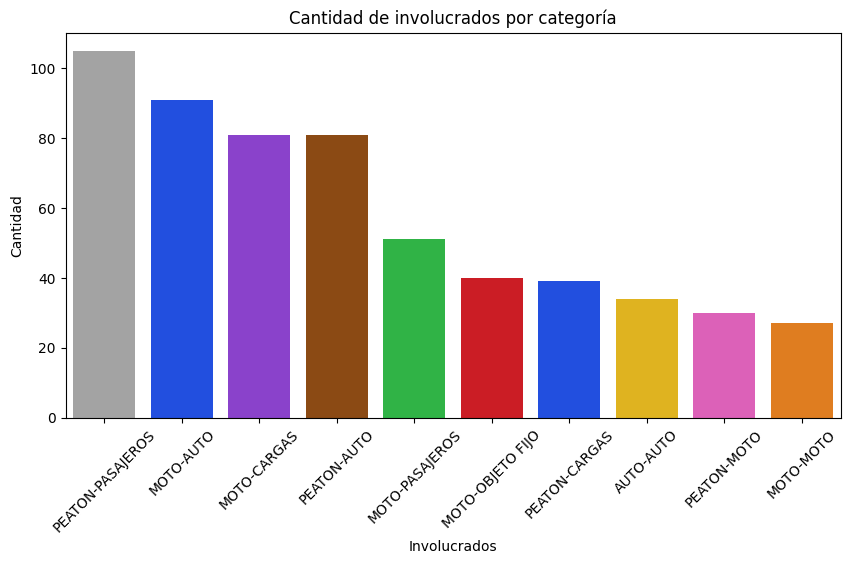

In [274]:
plt.figure(figsize=(10,5))
ax=sns.countplot(data=df, x='involucrados', hue='involucrados', palette='bright', order=df['involucrados'].value_counts().index[:10])
ax.set_title('Cantidad de involucrados por categoría')
ax.set_xlabel('Involucrados')
ax.set_ylabel('Cantidad')
plt.xticks(fontsize=10, rotation=45);


In [275]:
df['involucrados'].value_counts(normalize=True).head(10)

involucrados
PEATON-PASAJEROS    0.148515
MOTO-AUTO           0.128713
MOTO-CARGAS         0.114569
PEATON-AUTO         0.114569
MOTO-PASAJEROS      0.072136
MOTO-OBJETO FIJO    0.056577
PEATON-CARGAS       0.055163
AUTO-AUTO           0.048091
PEATON-MOTO         0.042433
MOTO-MOTO           0.038190
Name: proportion, dtype: float64

### INSIGHT
Si bien se analizado las víctimas y los acusados por separado, a la hora de ver los involucrados en los accidentes tenemos que una preponderancia de 4 tipos de siniestros mas comunes siendo el primero la víctima y el segundo el acusado.
Los siniestros *PEATON-PASAJEROS*, *MOTO-AUTO*, *MOTO-CARGAS* y *PEATON-AUTO* son de los mas comunes representando alrededor del 40% de los tipos de siniestros.


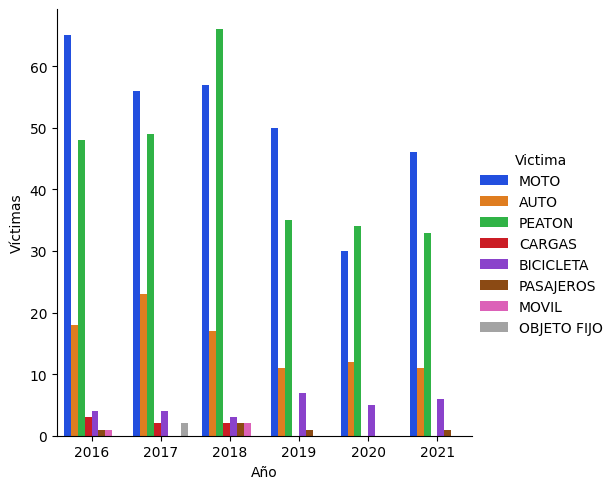

In [276]:
g=sns.catplot(data=df, x=df['fecha'].dt.year, hue='victima', kind='count', palette='bright')
g.set_xlabels('Año')
g.set_ylabels('Víctimas')
g._legend.set_title('Victima');

### INSIGHTS
Si revisamos a simple vista el gráfico anterior podemos ver como en lineas generales las víctimas de todo tipo tiene una tendencia en la baja de la cantidad de siniestros excepto la categoría *BICICLETA* que ha aumentado en los últimos 3 años.
Es importante remarcar que la categoría *MOTO* el último año tuvo un repunte

In [277]:
df_grouped=df.groupby(['año','semestre','victima'])['id_hecho'].count()
df_grouped=df_grouped.to_frame()

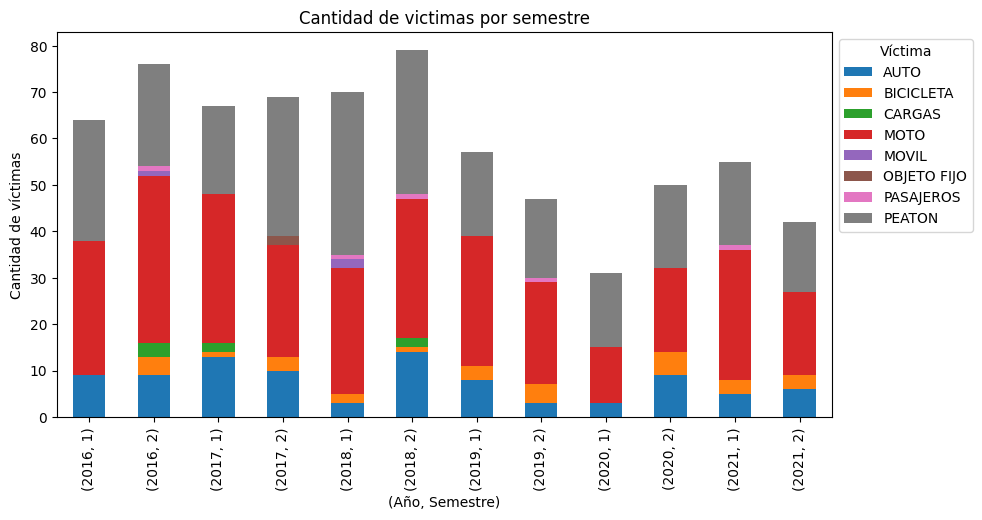

In [278]:
# Cambia la forma del DataFrame para que cada 'victima' sea una columna
df_pivot = df_grouped.pivot_table(values='id_hecho', index=['año', 'semestre'], columns='victima', fill_value=0)

# Crea el gráfico de barras apiladas
ax=df_pivot.plot(kind='bar', stacked=True,figsize=(10,5))
ax.set_title('Cantidad de victimas por semestre')
ax.set_xlabel('(Año, Semestre)')
ax.set_ylabel('Cantidad de víctimas')
ax.legend(title='Víctima',loc='upper left',bbox_to_anchor=(1,1));

### INSIGHT
Como se puede ver en el gráfico de arriba si bien la tendencia es a la baja de víctimas de siniestros, en los ultimos 3 semestres parece haber un repunte para luego volver a disminuir un poco el último semestre.

In [279]:
anterior=0
x=list()
y=list()
años=df.groupby('año')['victima'].count()
for indice,año in enumerate(años):
    if indice==0:
        anterior=año
        continue
    variacion=(año-anterior)*100/anterior
    x.append(años.index[indice])
    y.append(variacion)
    anterior=año

In [280]:
df_variacion_interanual=pd.DataFrame({'Año':x,'Variación interanual (%)':y})

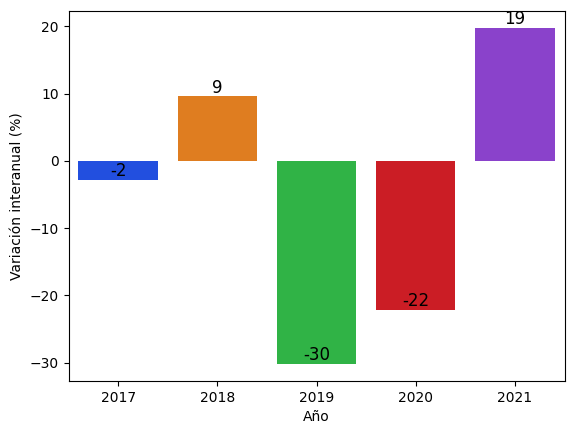

In [281]:
barplot=sns.barplot(data=df_variacion_interanual,x='Año',y='Variación interanual (%)',palette='bright')

for p in barplot.patches:
    barplot.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()), 
                 fontsize=12, color='black', ha='center', va='bottom')

### INSGHT
Si observamos las variaciones interanuales podemos ver un brusco descenso en el año 2019 y si bien siguió descendiendo en el 2020 este descenso fue menor y llegamos al año 2021 con un aumento relativo de la cantidad de víctimas.

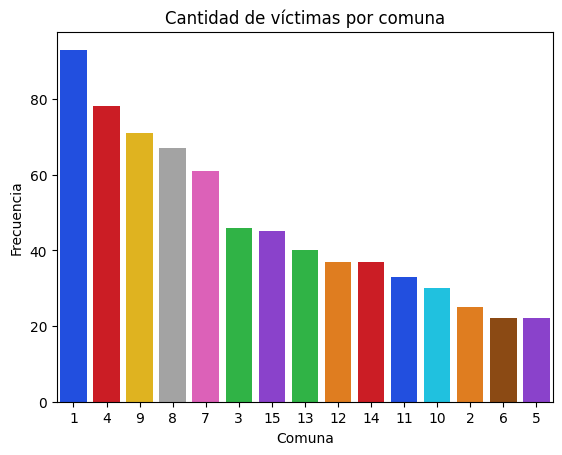

In [282]:
ax=sns.countplot(data=df, x='comuna', hue='comuna', palette='bright',legend=False, order=df['comuna'].value_counts().index)
ax.set_title('Cantidad de víctimas por comuna')
ax.set_xlabel('Comuna')
ax.set_ylabel('Frecuencia');


In [283]:
df['comuna'].value_counts(normalize=True)

comuna
1     0.131542
4     0.110325
9     0.100424
8     0.094767
7     0.086280
3     0.065064
15    0.063649
13    0.056577
12    0.052334
14    0.052334
11    0.046676
10    0.042433
2     0.035361
6     0.031117
5     0.031117
Name: proportion, dtype: float64

### INSIGHT
Es importante destacar las primeras 5 comunas que registran más del 50% de las víctimas.

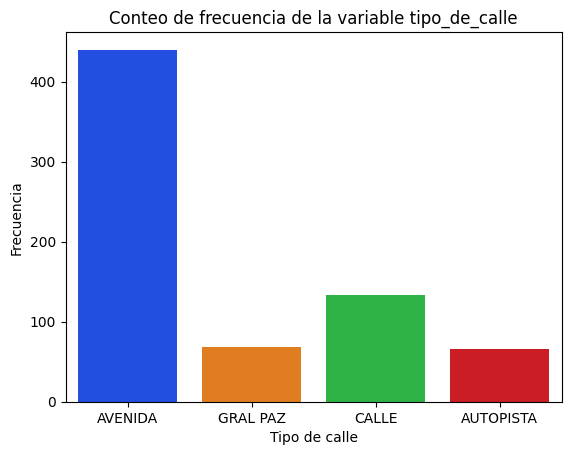

In [284]:
ax=sns.countplot(data=df, x='tipo_de_calle', hue='tipo_de_calle', palette='bright')
ax.set_title('Conteo de frecuencia de la variable tipo_de_calle')
ax.set_xlabel('Tipo de calle')
ax.set_ylabel('Frecuencia');


In [285]:
df['tipo_de_calle'].value_counts(normalize=True)

tipo_de_calle
AVENIDA      0.622348
CALLE        0.188119
GRAL PAZ     0.096181
AUTOPISTA    0.093352
Name: proportion, dtype: float64

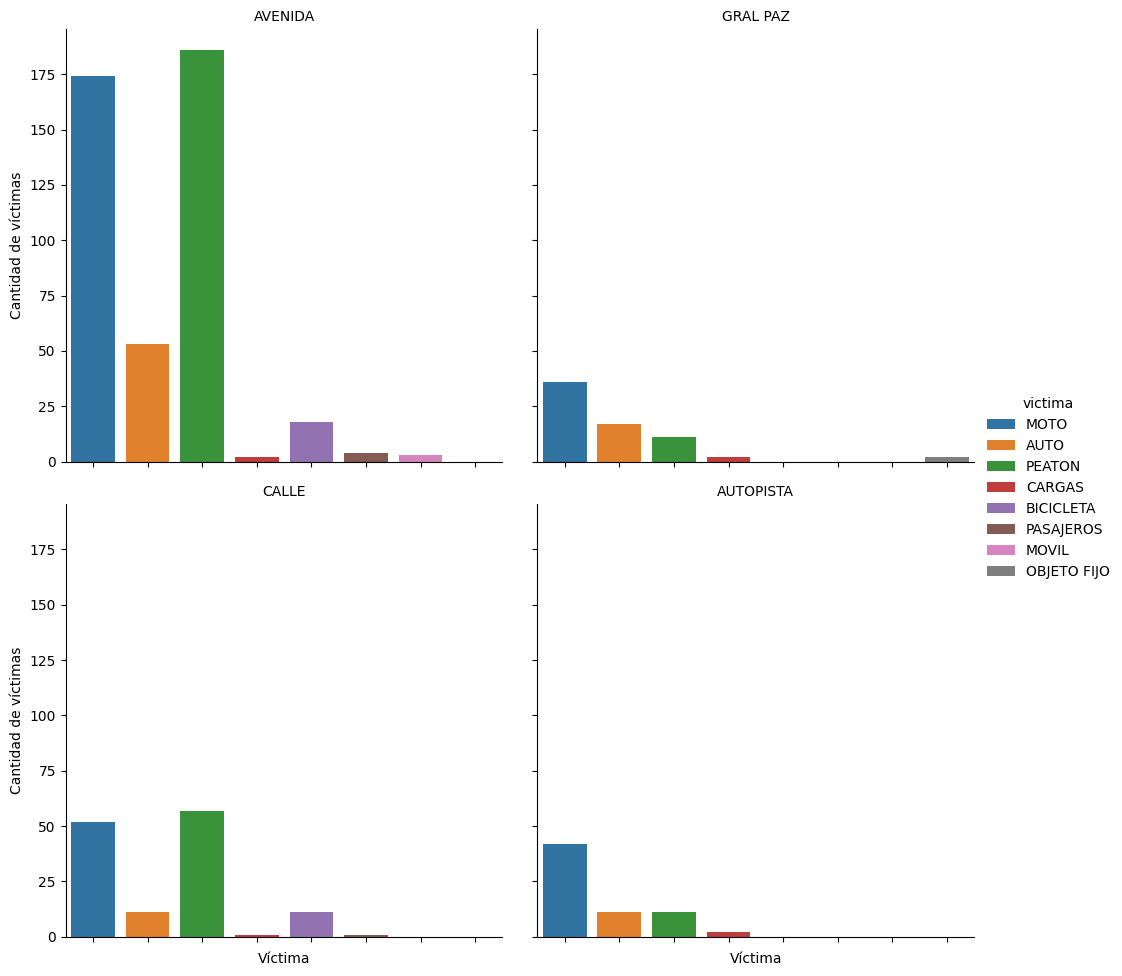

In [286]:
g=sns.catplot(data=df, x='victima', hue='victima', kind='count', col='tipo_de_calle', col_wrap=2,legend=True)
g.set_axis_labels('Víctima', 'Cantidad de víctimas')
g.set_titles("{col_name}")
axes = g.axes

# Recorre los objetos Axes y establece las etiquetas del eje x a una lista vacía
for ax in axes.flatten():
    ax.set_xticklabels([]);

### INSIGHT
La mayor cantidad de siniestros que terminan con víctimas fatales se dan en las *avenidas*, cuyo límite de velocidad es de 60 km/hr según [información oficial](https://www.argentina.gob.ar/transito/consejos-para-circular#:~:text=Velocidades%20permitidas,nivel%3A%2020%20km%2Fh.).

Y como podemos ver también en la cantidad de víctimas por tipo de calle y donde diferenciamos el tipo de victima, en las avenidas la mayor cantidad es *MOTO* y *PEATON*.

### Matriz de correlación

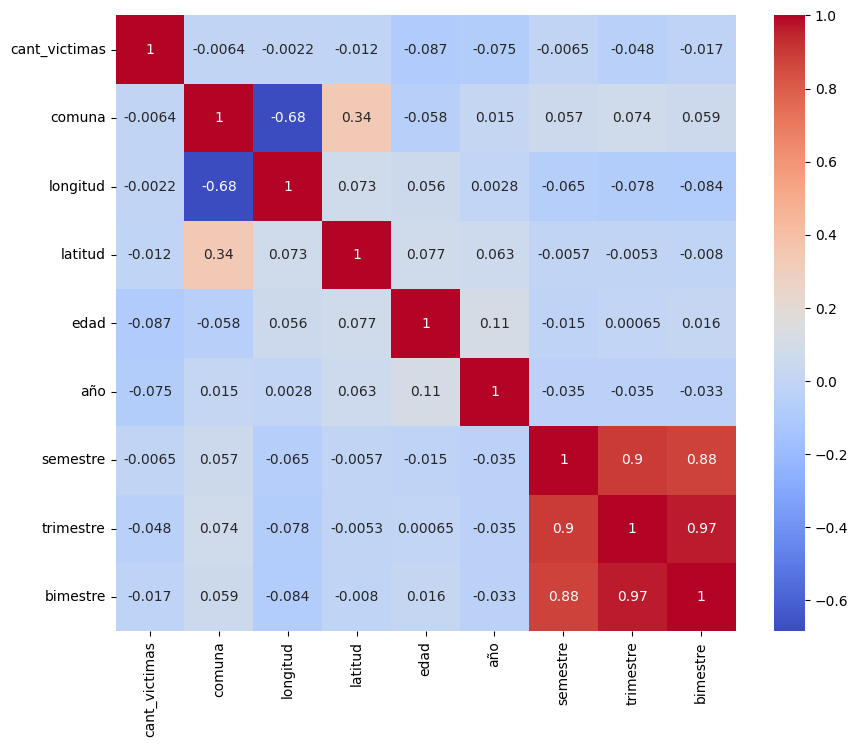

In [287]:
# Selecciona solo las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Calcula la matriz de correlación
corr_matrix = df_numeric.corr()

# Crea una heatmap con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

In [288]:
df

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,longitud,latitud,involucrados,...,acusado,rol,sexo,edad,año,semestre,trimestre,bimestre,mes,dia
0,2016-0001,1,2016-01-01,1900-01-01 04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,8,-58.475340,-34.687570,MOTO-AUTO,...,AUTO,CONDUCTOR,MASCULINO,19,2016,1,1,1,Enero,Viernes
1,2016-0002,1,2016-01-02,1900-01-01 01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,9,-58.508775,-34.669777,AUTO-PASAJEROS,...,PASAJEROS,CONDUCTOR,MASCULINO,70,2016,1,1,1,Enero,Sábado
2,2016-0003,1,2016-01-03,1900-01-01 07:00:00,AV ENTRE RIOS 2034,AVENIDA,1,-58.390403,-34.631894,MOTO-AUTO,...,AUTO,CONDUCTOR,MASCULINO,30,2016,1,1,1,Enero,Domingo
3,2016-0004,1,2016-01-10,1900-01-01 00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,8,-58.465039,-34.680930,MOTO-AUTO,...,AUTO,CONDUCTOR,MASCULINO,18,2016,1,1,1,Enero,Domingo
4,2016-0005,1,2016-01-21,1900-01-01 05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,1,-58.387183,-34.622466,MOTO-PASAJEROS,...,PASAJEROS,CONDUCTOR,MASCULINO,29,2016,1,1,1,Enero,Jueves
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2021-0093,1,2021-12-13,1900-01-01 17:10:00,AV. RIESTRA Y MOM,AVENIDA,7,-58.433538,-34.645616,MOTO-AUTO,...,AUTO,PASAJERO_ACOMPAÑANTE,FEMENINO,18,2021,2,4,6,Diciembre,Lunes
703,2021-0094,1,2021-12-20,1900-01-01 01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,9,-58.467398,-34.651178,MOTO-AUTO,...,AUTO,PASAJERO_ACOMPAÑANTE,FEMENINO,43,2021,2,4,6,Diciembre,Lunes
704,2021-0095,1,2021-12-30,1900-01-01 00:43:00,AV. GAONA Y TERRADA,AVENIDA,11,-58.472934,-34.619847,MOTO-CARGAS,...,CARGAS,CONDUCTOR,MASCULINO,27,2021,2,4,6,Diciembre,Jueves
705,2021-0096,1,2021-12-15,1900-01-01 10:30:00,AV. EVA PERON 4071,AVENIDA,9,-58.470668,-34.650217,AUTO-CARGAS,...,CARGAS,CONDUCTOR,MASCULINO,60,2021,2,4,6,Diciembre,Miércoles


### Mapa de calor

In [289]:
import folium
from folium.plugins import HeatMap

df_coordenadas= df.dropna(subset=['latitud', 'longitud'])
# Supongamos que df es tu DataFrame y que 'lat' y 'lon' son tus columnas de latitud y longitud
data = df_coordenadas[['latitud', 'longitud']].values



# Crea un mapa centrado en la media de las latitudes y longitudes
map_heat = folium.Map(location=[df_coordenadas['latitud'].mean(), df_coordenadas['longitud'].mean()], zoom_start=13)

# Agrega el mapa de calor al mapa
HeatMap(data).add_to(map_heat)

# Muestra el mapa
map_heat

### INSIGHT
Podemos observar como la mayor concentración de siniestros se dió al este de la Ciudad Autónoma de Buenos Aires.